# **Regression lineaire sur les top sons de Spotify dans 73 pays**
# *Michy Elouan & Denoel Niels*

**lien de la base étudiée** : https://www.kaggle.com/datasets/asaniczka/top-spotify-songs-in-73-countries-daily-updated/data

---

# **1 - INTRODUCTION**
---

**Contexte** : Ce projet porte sur l'analyse d'une base de données contenant des informations détaillées sur les musiques disponibles sur Spotify. Chaque morceau est décrit par des variables telles que la durée, le genre, l'année de sortie, le tempo, ainsi que diverses caractéristiques acoustiques. L'objectif est d'explorer les relations entre ces variables afin de mieux comprendre leurs interactions et leur influence sur certains aspects de l'expérience musicale sur la plateforme.

**Problématique** : Quels sont les liens entre la popularité des musiques et les différentes caractéristiques des morceaux disponibles sur Spotify, telles que la durée, le genre, l'année de sortie, le tempo et d'autres attributs acoustiques ?

**Enjeux** : Analyser la popularité d'une chanson, une mesure abstraite et subjective influencée par les goûts individuels, en fonction de ses attributs musicaux. La popularité, en tant qu'évaluation relative et non physique, se distingue des autres variables comme la durée, le tempo ou le genre, qui sont des caractéristiques objectives et mesurables.

# **2 - EXPLORATION DES DONNEES**
---
## 2.1 - Visualisation & Informations des données brutes
---

In [106]:
# Importation des bibliothèques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import skew, boxcox, kstest, jarque_bera
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import linear_rainbow, linear_reset, het_white
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import shapiro

In [5]:
# Importation des données du fichier et lecture du affichage
Base = pd.read_csv("universal_top_spotify_songs.csv")

Observons les données brutes en commençant par les **dimensions** et les **premières lignes** de notre dataset

In [7]:
Base.head()
N, P = Base.shape
print("Notre base de données comporte : \nn =", N, "observations\np =", P, "variables")

print("Visualisation")
Base.head()

Notre base de données comporte : 
n = 1695944 observations
p = 25 variables
Visualisation


,spotify_id,name,artists,daily_rank,daily_movement,weekly_movement,country,snapshot_date,popularity,is_explicit,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,2plbrEY59IikOBgBGLjaoe,Die With A Smile,"Lady Gaga, Bruno Mars",1,0,0,NaN,2025-02-08,99,False,...,6,-7.777,0,0.0304,0.3080,0.0000,0.1220,0.535,157.969,3
1,5ZLUm9eab8y3tqQ1OhQSHI,Abracadabra,Lady Gaga,2,3,48,NaN,2025-02-08,84,False,...,10,-3.487,0,0.0624,0.0121,0.0000,0.2220,0.633,126.004,4
2,4wJ5Qq0jBN4ajy7ouZIV1c,APT.,"ROSÉ, Bruno Mars",3,1,0,NaN,2025-02-08,91,False,...,0,-4.477,0,0.2600,0.0283,0.0000,0.3550,0.939,149.027,4
3,3sK8wGT43QFpWrvNQsrQya,DtMF,Bad Bunny,4,-2,-2,NaN,2025-02-08,98,True,...,7,-27.405,0,0.0717,0.1770,0.2180,0.0807,0.032,136.020,4
4,6dOtVTDdiauQNBQEDOtlAB,BIRDS OF A FEATHER,Billie Eilish,5,-2,3,NaN,2025-02-08,96,False,...,2,-10.171,1,0.0358,0.2000,0.0608,0.1170,0.438,104.978,4


## 2.2 -  Informations sur les variables 
---

On veut maintenant s'intéresser à la nature de nos variables.

In [9]:
Base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1695944 entries, 0 to 1695943
Data columns (total 25 columns):
 #   Column              Dtype  
---  ------              -----  
 0   spotify_id          object 
 1   name                object 
 2   artists             object 
 3   daily_rank          int64  
 4   daily_movement      int64  
 5   weekly_movement     int64  
 6   country             object 
 7   snapshot_date       object 
 8   popularity          int64  
 9   is_explicit         bool   
 10  duration_ms         int64  
 11  album_name          object 
 12  album_release_date  object 
 13  danceability        float64
 14  energy              float64
 15  key                 int64  
 16  loudness            float64
 17  mode                int64  
 18  speechiness         float64
 19  acousticness        float64
 20  instrumentalness    float64
 21  liveness            float64
 22  valence             float64
 23  tempo               float64
 24  time_signature      int6

### Les variables représentent les données suivantes:

- **spotify_id** : identifiant unique du son spotify  (_qualitatif_)  
- **name** : le titre de la musique (_qualitatif_)
- **artists** : nom de ou des artistes associé à la musique (_qualitatif_)
- **daily_rank** : classement journalier du son sur les top 50 (**discrète**) (_quantitatif_)
- **daily_movement** : Évolution du classement par rapport à la veille (**discrète**) (_quantitatif_)
- **weekly_movement** : Évolution du classement par rapport à la semaine précédente (**discrète**) (_quantitatif_)
- **country** : Le code ISO du pays de la liste de lecture du Top 50. Si Null, la liste de lecture est « Global Top 50 » (_qualitatif_)
- **snapshot_date** : Date à laquelle les données ont été collectées à partir de l'API Spotify (_qualitatif_)
- **popularity** : mesure de la popularité actuelle de la chanson sur Spotify (**discrète**) (_quantitatif_)
- **is_explicit** : Indique s'il y a des des musiques contennant des paroles explicite (_qualitatif_)
- **duration_ms** : La durée de la musique en micro seconde (**discrète**) (_quantitatif_)
- **album_name** : Titre de l'album contenant la musique (_qualitatif_)
- **album_release_date** : Date à laquelle l'album du son est sorti (_qualitatif_)
- **danceability** : le degré d'adéquation d'un morceau à la danse sur la base d'une combinaison d'éléments musicaux (**continue**) (_quantitatif_)
- **energy** : mesure de l'intensité et niveaux d'activité de la musique (**continue**) (_quantitatif_)
- **key** : La tonalité de la chanson (**discrète**) (_quantitatif_)
- **loudness** : L'intensité sonore globale de la chanson en décibels (**continue**) (_quantitatif_)
- **mode** : Indique si la chanson est dans une tonalité majeure ou mineure (**discrète**) (_quantitatif_)
- **speechiness** : Mesure la probabilité d'une chanson à contenir des paroles (**continue**) (_quantitatif_)
- **acoustiness** : Mesure de la qualité acoustique de la chanson (**continue**) (_quantitatif_)
- **instrumentalness** : Mesure de la probabilité que la chanson ne contienne pas de voix (**continue**) (_quantitatif_)
- **liveness** : Une mesure de la présence d'un public en direct dans l'enregistrement (**continue**) (_quantitatif_)
- **valence** : mesure de la positivité musicale véhiculée par la chanson (**continue**) (_quantitatif_)
- **tempo** : Le tempo de la chanson en battements par minute (**continue**) (_quantitatif_)
- **time_signature** : La signature temporelle globale estimée de la chanson (**discrète**) (_qualitatif_)

On a donc :
- 8 variables qualitatives
- 17 variables quantitatives

### Ajout de la variable Nb_days

La variable supplémentaire _*Nb_days*_ correspond au nombre de jours écoulés depuis la sortie de l'album. L'ajout de cette variable permet entre autre de renseigner si le temps écoulé depuis la sortie d'une musique a un impact sur la popularité de ladite musique. Il s'agit d'une variable quantitative, ce qui fait que nous avons au total **18 variables quantitatives**


In [116]:
#Convertion des dates en datetime64[ns]
Base["snapshot_date"] = pd.to_datetime(Base["snapshot_date"])
Base["album_release_date"] = pd.to_datetime(Base["album_release_date"])
Base["Nb_days"] = (Base["snapshot_date"]-Base["album_release_date"]).dt.days

In [118]:
# Information sur les données
n, p = Base.shape
Base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1695944 entries, 0 to 1695943
Data columns (total 26 columns):
 #   Column              Dtype         
---  ------              -----         
 0   spotify_id          object        
 1   name                object        
 2   artists             object        
 3   daily_rank          int64         
 4   daily_movement      int64         
 5   weekly_movement     int64         
 6   country             object        
 7   snapshot_date       datetime64[ns]
 8   popularity          int64         
 9   is_explicit         bool          
 10  duration_ms         int64         
 11  album_name          object        
 12  album_release_date  datetime64[ns]
 13  danceability        float64       
 14  energy              float64       
 15  key                 int64         
 16  loudness            float64       
 17  mode                int64         
 18  speechiness         float64       
 19  acousticness        float64       
 20  in

### Statistiques élémentaires 

In [121]:
Base.describe()

,daily_rank,daily_movement,weekly_movement,snapshot_date,popularity,duration_ms,album_release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Nb_days
count,1.695944e+06,1.695944e+06,1.695944e+06,1695944,1.695944e+06,1.695944e+06,1695286,1.695944e+06,1.695944e+06,1.695944e+06,1.695944e+06,1.695944e+06,1.695944e+06,1.695944e+06,1.695944e+06,1.695944e+06,1.695944e+06,1.695944e+06,1.695944e+06,1.695286e+06
mean,2.549206e+01,9.328185e-01,2.819082e+00,2024-06-09 20:44:24.037019648,7.612732e+01,1.931531e+05,2022-02-27 21:45:52.598913024,6.798296e-01,6.497425e-01,5.542918e+00,-6.598156e+00,5.383745e-01,9.485152e-02,2.742340e-01,1.994162e-02,1.706515e-01,5.503813e-01,1.222373e+02,3.901591e+00,8.329550e+02
min,1.000000e+00,-4.900000e+01,-4.900000e+01,2023-10-18 00:00:00,0.000000e+00,0.000000e+00,1900-01-01 00:00:00,0.000000e+00,2.010000e-05,0.000000e+00,-5.434100e+01,0.000000e+00,0.000000e+00,3.450000e-06,0.000000e+00,1.390000e-02,0.000000e+00,0.000000e+00,0.000000e+00,-1.400000e+01
25%,1.300000e+01,-1.000000e+00,-3.000000e+00,2024-02-11 00:00:00,6.500000e+01,1.613420e+05,2023-05-16 00:00:00,5.860000e-01,5.510000e-01,2.000000e+00,-7.805000e+00,0.000000e+00,3.860000e-02,6.710000e-02,0.000000e+00,9.610000e-02,3.710000e-01,1.000160e+02,4.000000e+00,5.000000e+01
50%,2.500000e+01,0.000000e+00,0.000000e+00,2024-06-10 00:00:00,8.000000e+01,1.857220e+05,2023-11-28 00:00:00,7.010000e-01,6.690000e-01,6.000000e+00,-6.017000e+00,1.000000e+00,5.780000e-02,1.890000e-01,1.280000e-06,1.210000e-01,5.520000e-01,1.199620e+02,4.000000e+00,1.340000e+02
75%,3.800000e+01,2.000000e+00,5.000000e+00,2024-10-04 00:00:00,8.800000e+01,2.181330e+05,2024-05-17 00:00:00,7.830000e-01,7.650000e-01,9.000000e+00,-4.708000e+00,1.000000e+00,1.100000e-01,4.370000e-01,8.460000e-05,2.050000e-01,7.360000e-01,1.400930e+02,4.000000e+00,3.590000e+02
max,5.000000e+01,4.900000e+01,4.900000e+01,2025-02-08 00:00:00,1.000000e+02,9.396660e+05,2025-02-07 00:00:00,9.880000e-01,9.980000e-01,1.100000e+01,3.233000e+00,1.000000e+00,9.390000e-01,9.960000e-01,9.950000e-01,9.780000e-01,9.920000e-01,2.360890e+02,5.000000e+00,4.531100e+04
std,1.442890e+01,7.019333e+00,1.215320e+01,NaN,1.573198e+01,4.960356e+04,NaN,1.406630e-01,1.661562e-01,3.578755e+00,3.251979e+00,4.985254e-01,9.082899e-02,2.507885e-01,1.025156e-01,1.247351e-01,2.293140e-01,2.810990e+01,4.037049e-01,2.527101e+03


## 2.3 - Observations des valeurs manquantes
---

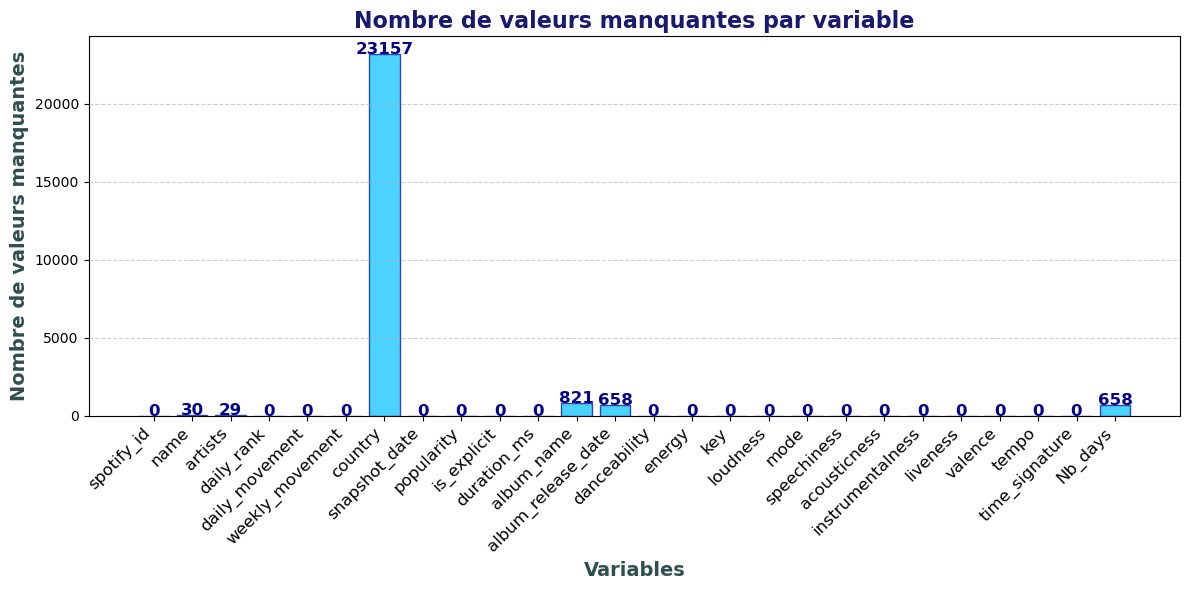

In [17]:
# Calcul du nombre de valeurs manquantes pour chaque colonne
liste_manquante = Base.isna().sum().tolist()

# Création de la figure
plt.figure(figsize=(12, 6))

# Barplot avec un design plus esthétique
bars = plt.bar([i for i in range(len(liste_manquante))], liste_manquante, color='deepskyblue', edgecolor='darkblue', alpha=0.7)

# Ajout des annotations avec ajustement
for i, v in enumerate(liste_manquante):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=12, fontweight='bold', color='darkblue')

# Ajouter un titre
plt.title("Nombre de valeurs manquantes par variable", fontsize=16, fontweight='bold', color='midnightblue')

# Ajouter les labels des axes
plt.xlabel("Variables", fontsize=14, fontweight='bold', color='darkslategray')
plt.ylabel("Nombre de valeurs manquantes", fontsize=14, fontweight='bold', color='darkslategray')

# Ajouter des grilles subtiles pour mieux repérer les valeurs
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Améliorer les x-ticks pour que les labels ne se chevauchent pas
plt.xticks(range(len(liste_manquante)), Base.columns, rotation=45, ha="right", fontsize=12)

# Ajuster la mise en page pour éviter tout chevauchement
plt.tight_layout()

# Afficher le graphique
plt.show()


On observe un pic de valeurs manquantes pour la donnée **_country_**. Un moyen de pallier à ce manque serait de remplacer les valeurs NaN par le mode (valeur la plus présente). Cependant, il est indiqué que si les valeurs sont NaN pour **_country_**, on peut utiliser la valeur 'WW' qui désigne le top 50 global dans le monde.

On observe également deux colonnes avec le même nombre de valeurs NaN (658). Cela s'explique par le fait que la dernière colonne, qui correspond à Nb_days, dépend entre autre de la variable "album_release_date". Elles ont donc le même nombre de valeurs NaN.

On remplace les valeurs NaN dans la dernière variable **_Nb_days_** par la médiane pour les variables quantitatives car elle figure une meilleure robustesse sur les valeurs aberrantes et minimise l'impact sur la moyenne 

In [20]:
# Remplacement des données
Base["Nb_days"] = Base["Nb_days"].fillna(Base["Nb_days"].median())
Base["country"] = Base["country"].fillna("WW")

## 2.4 - Visualisation des histogrammes et des boxplots des données quantitatives pour $n_{e} = 50 000$
---

Les boxplots et les histogrammes fournissent des informations essentielles pour la compréhension des données brutes avant d'effectuer une régression linéaire. Une distribution asymétrique ou des valeurs extrêmes peuvent affecter les coefficients de régression et rendre le modèle moins fiable, et la présence de valeurs aberrantes peut fausser la pente et l’interception estimées.

Au vu du nombre d'observation de la base de donnée, on décide d'utiliser un échantillon de taille : $n_{e} = 50 000$

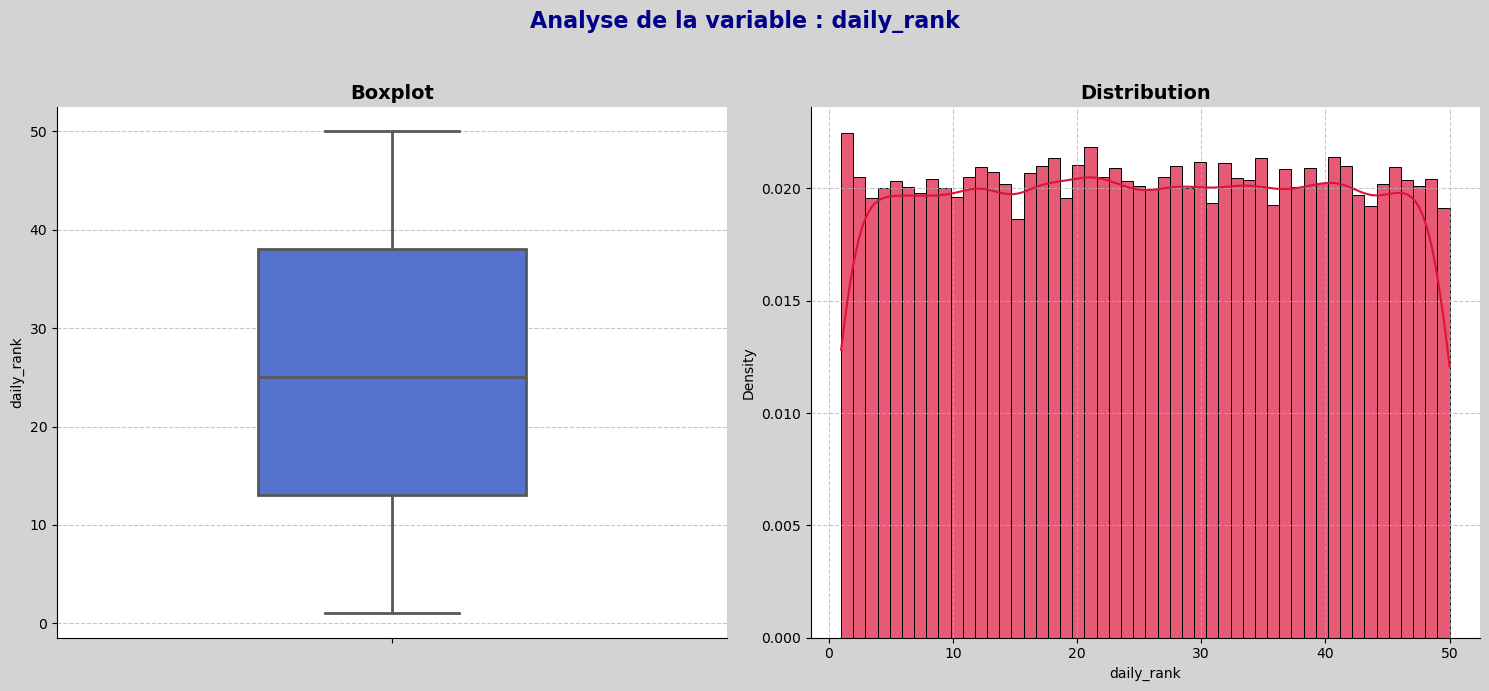

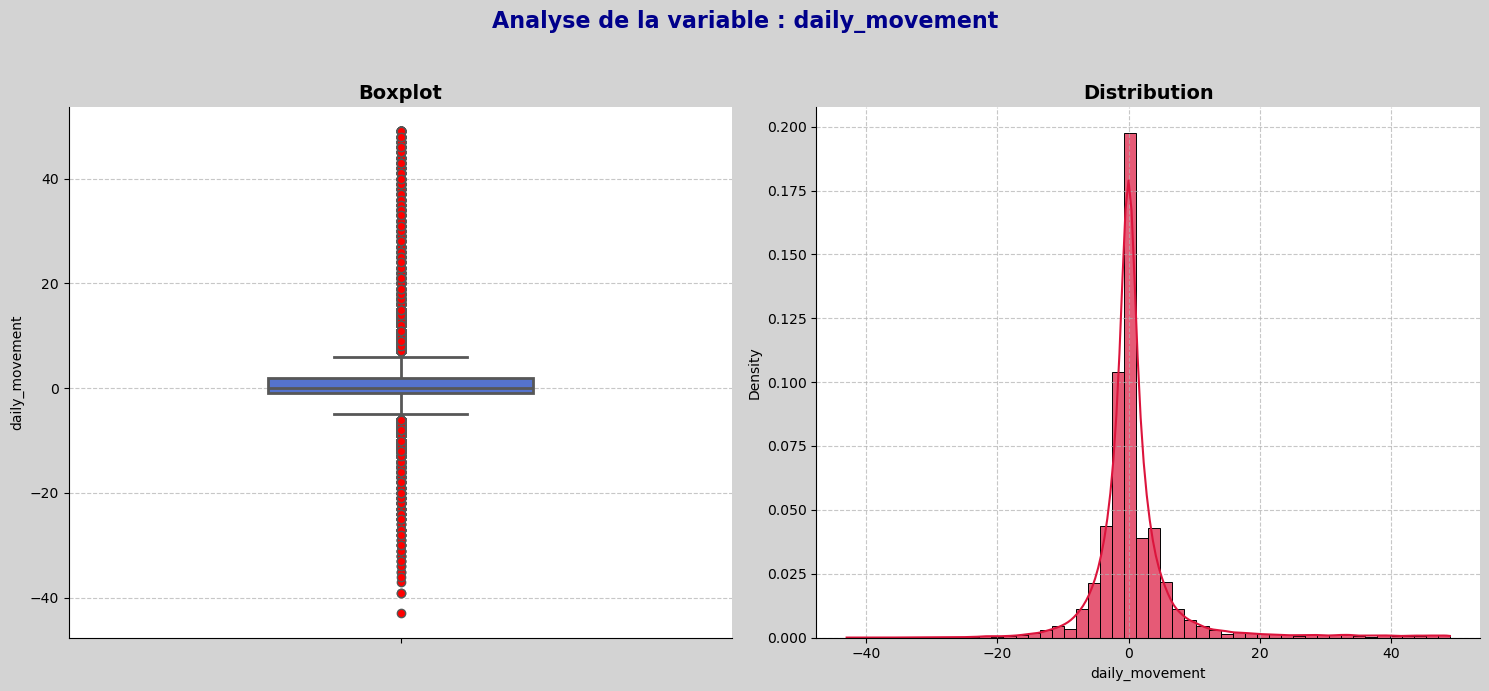

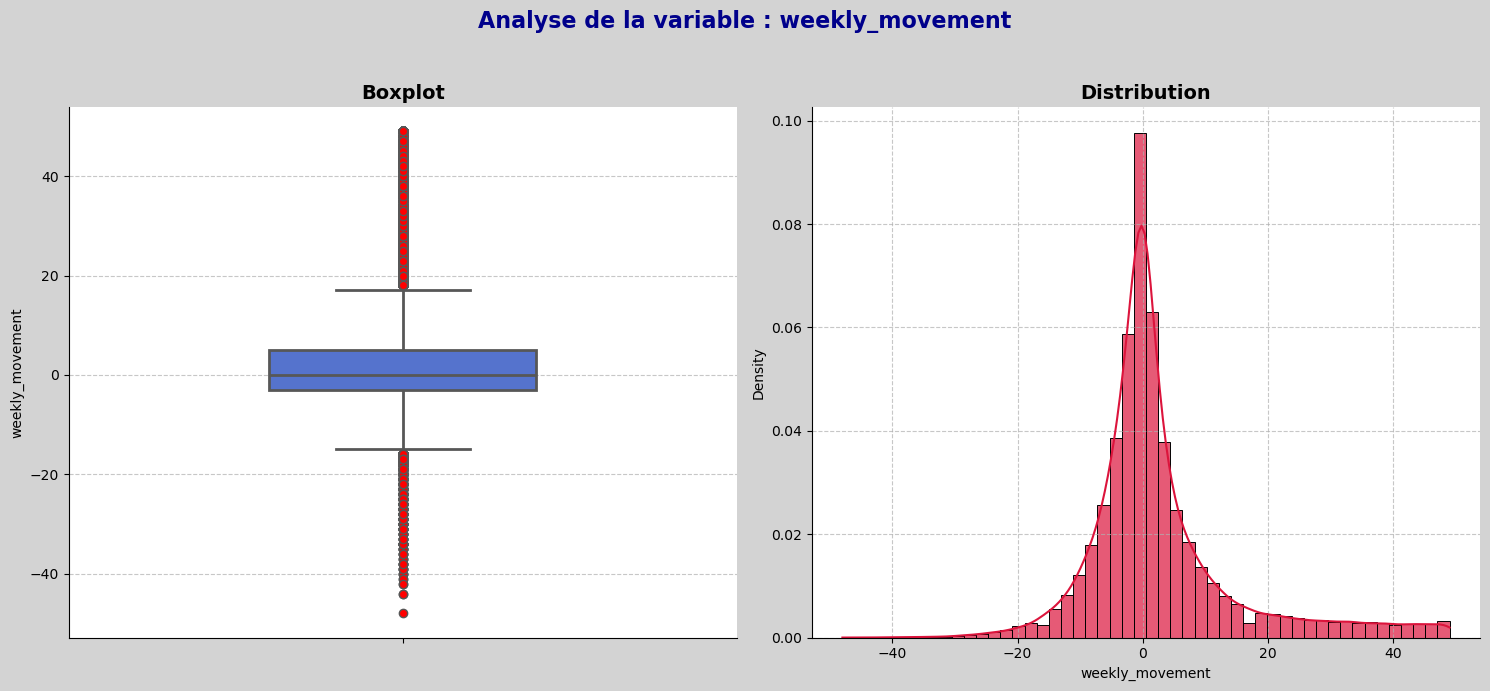

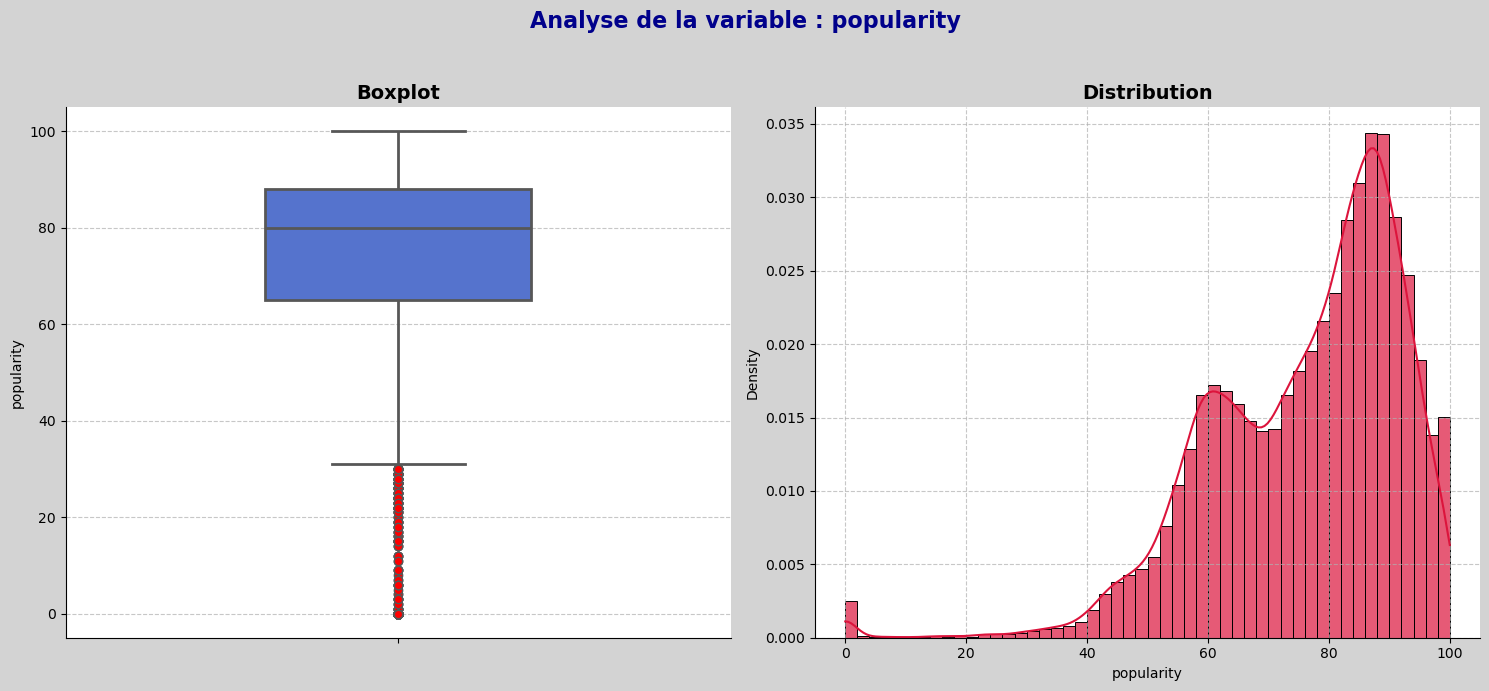

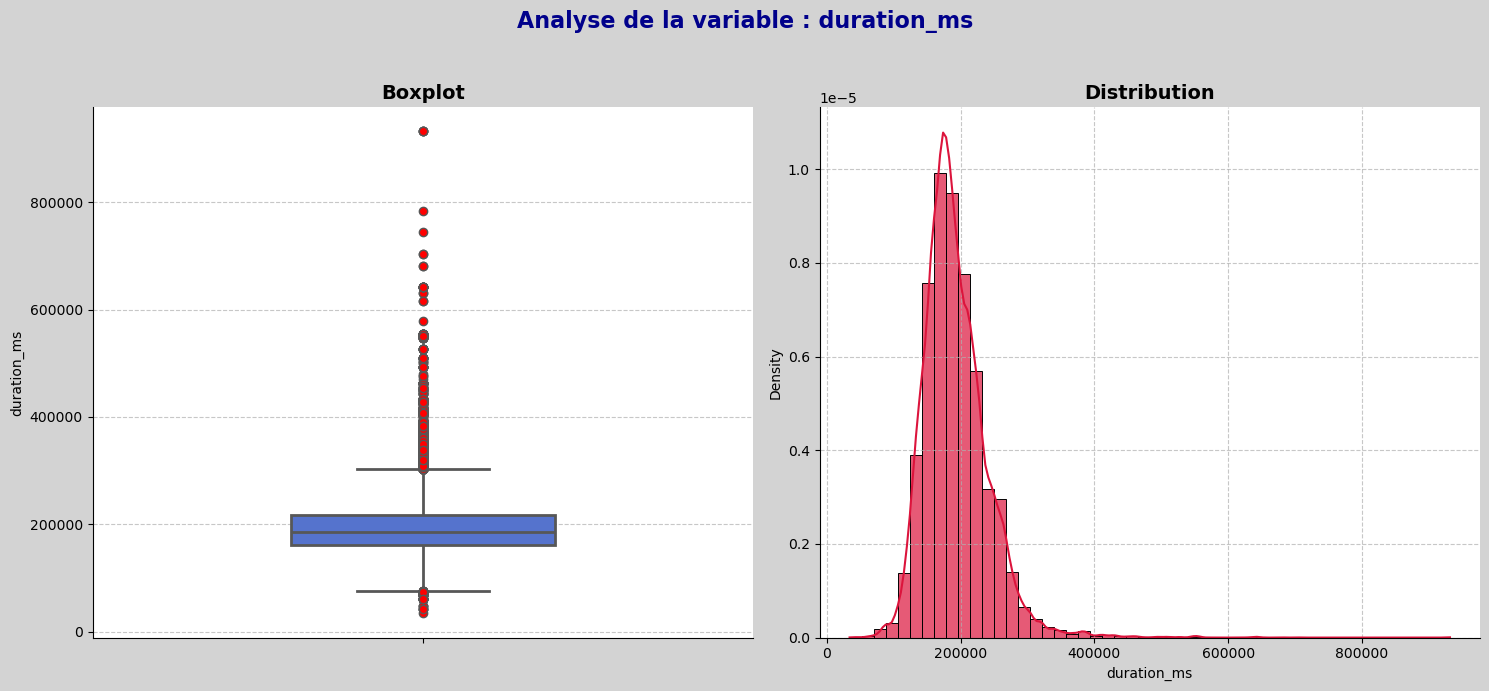

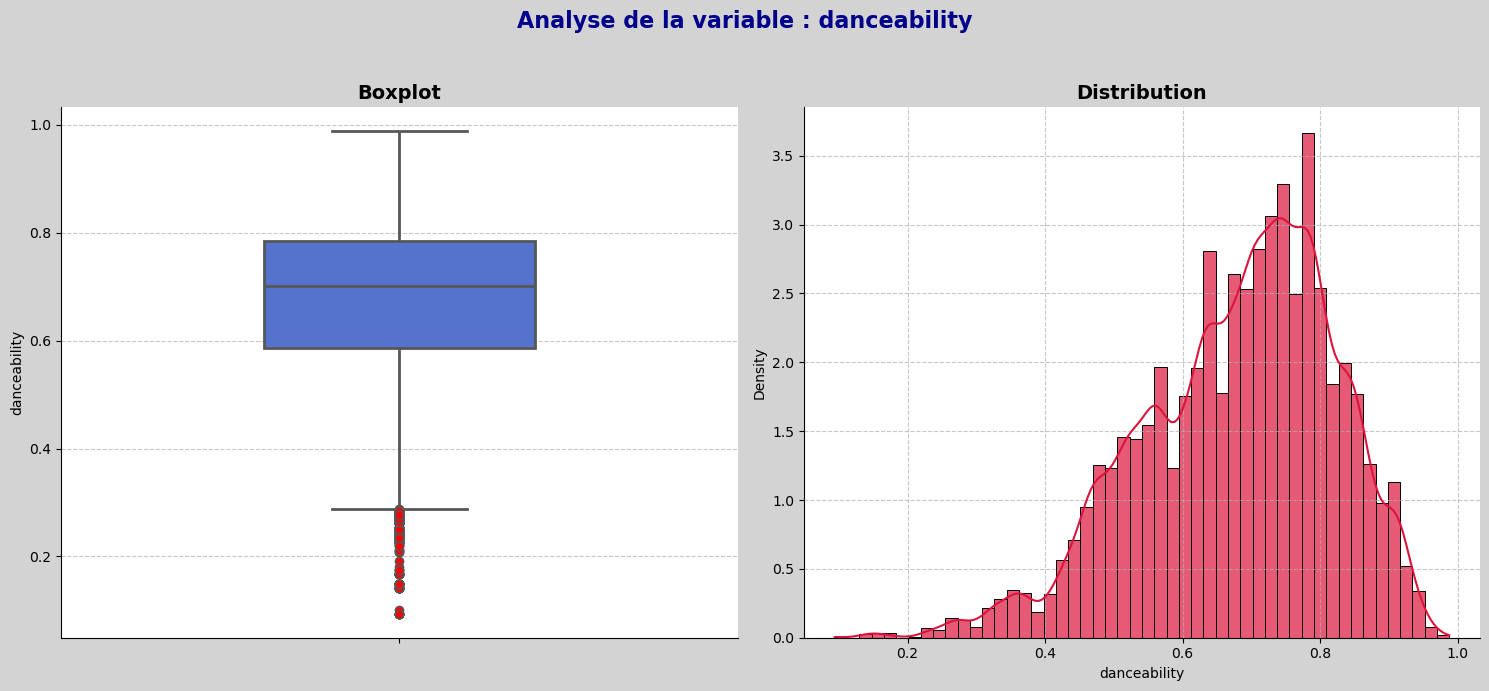

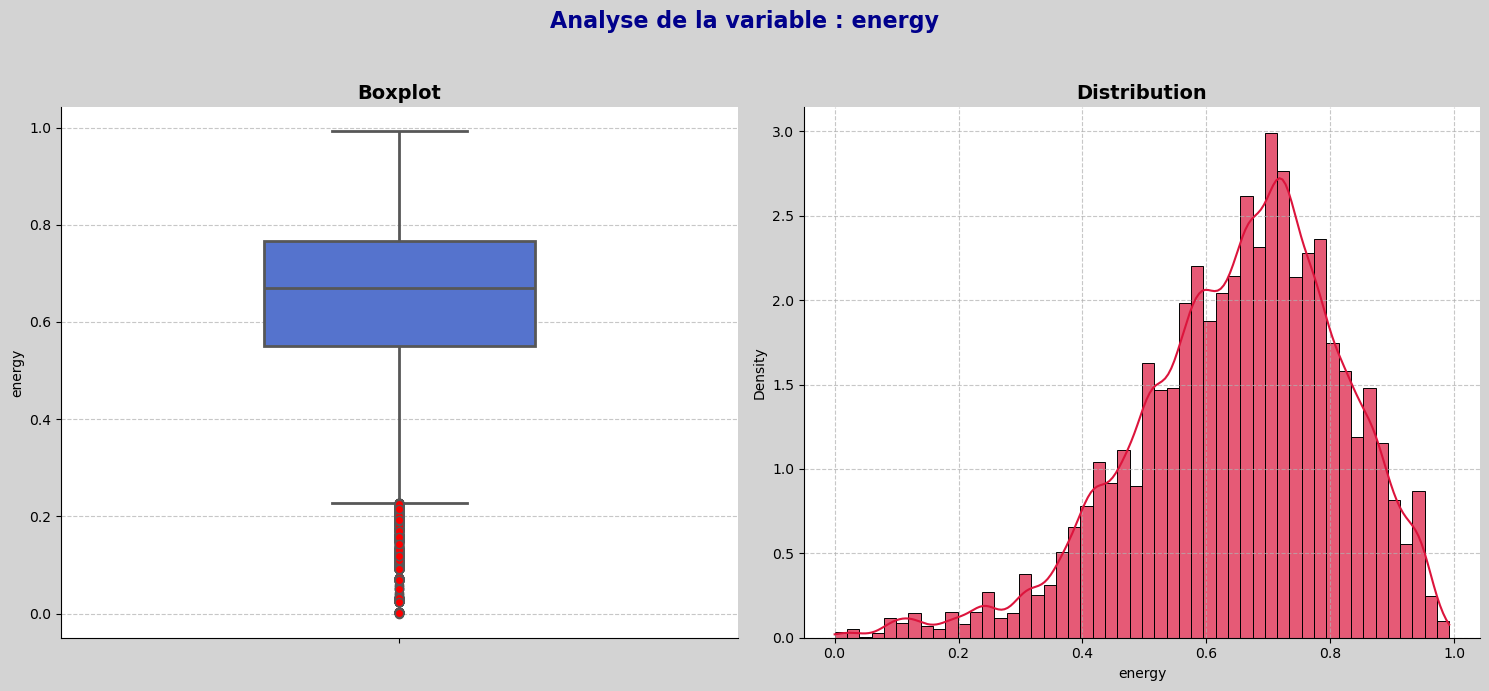

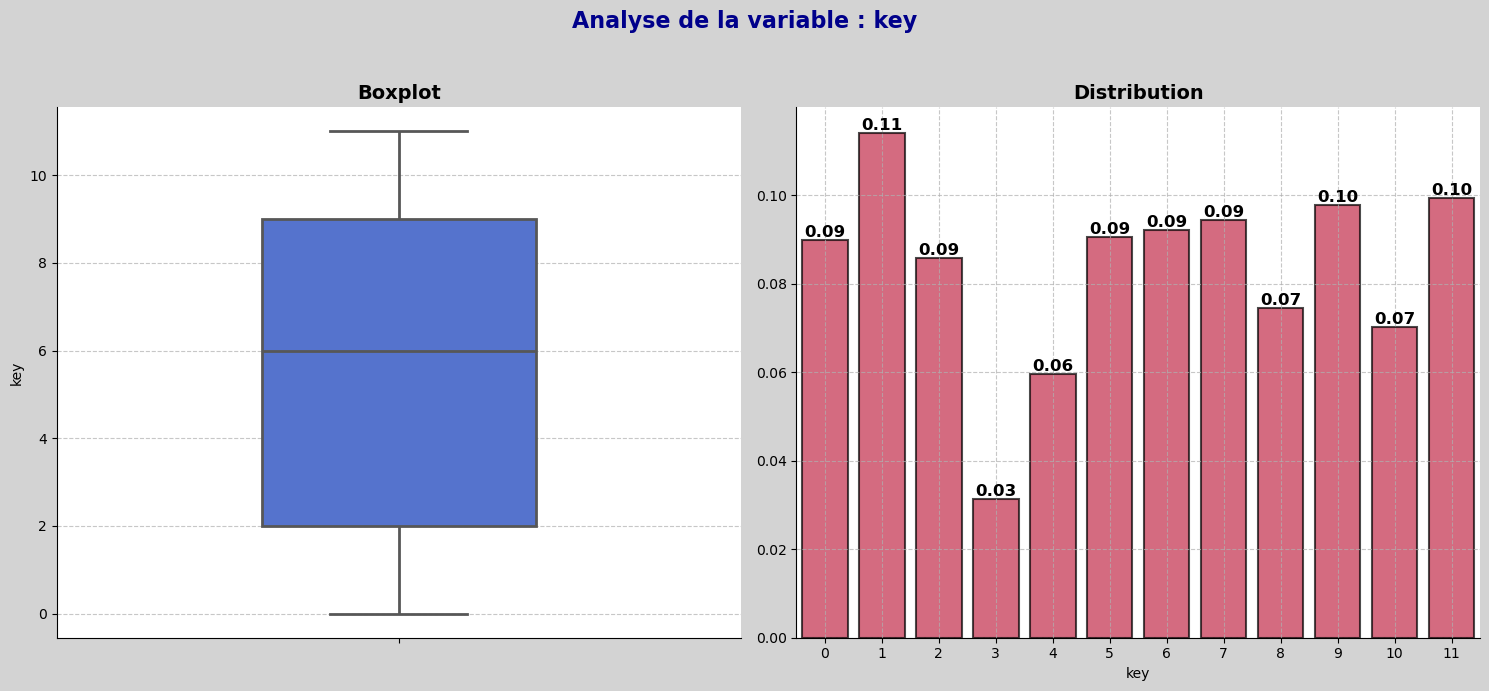

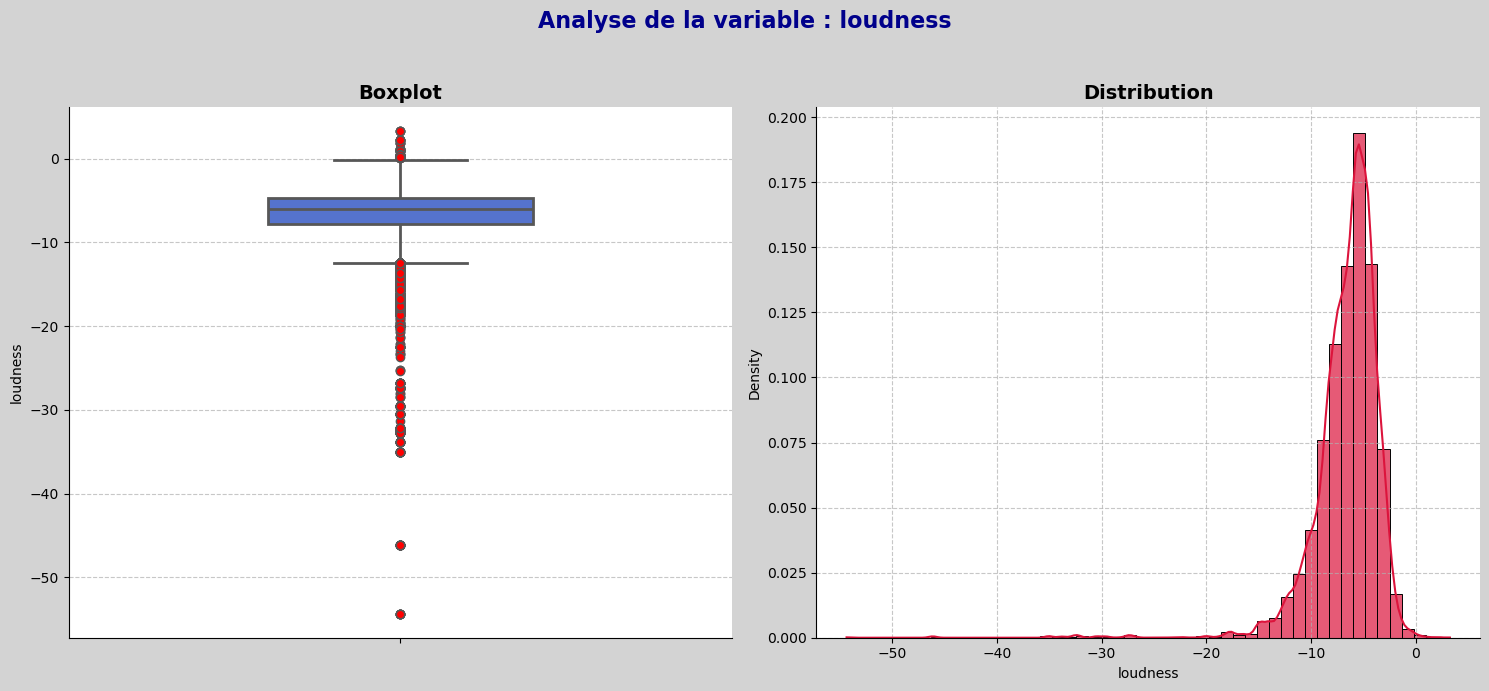

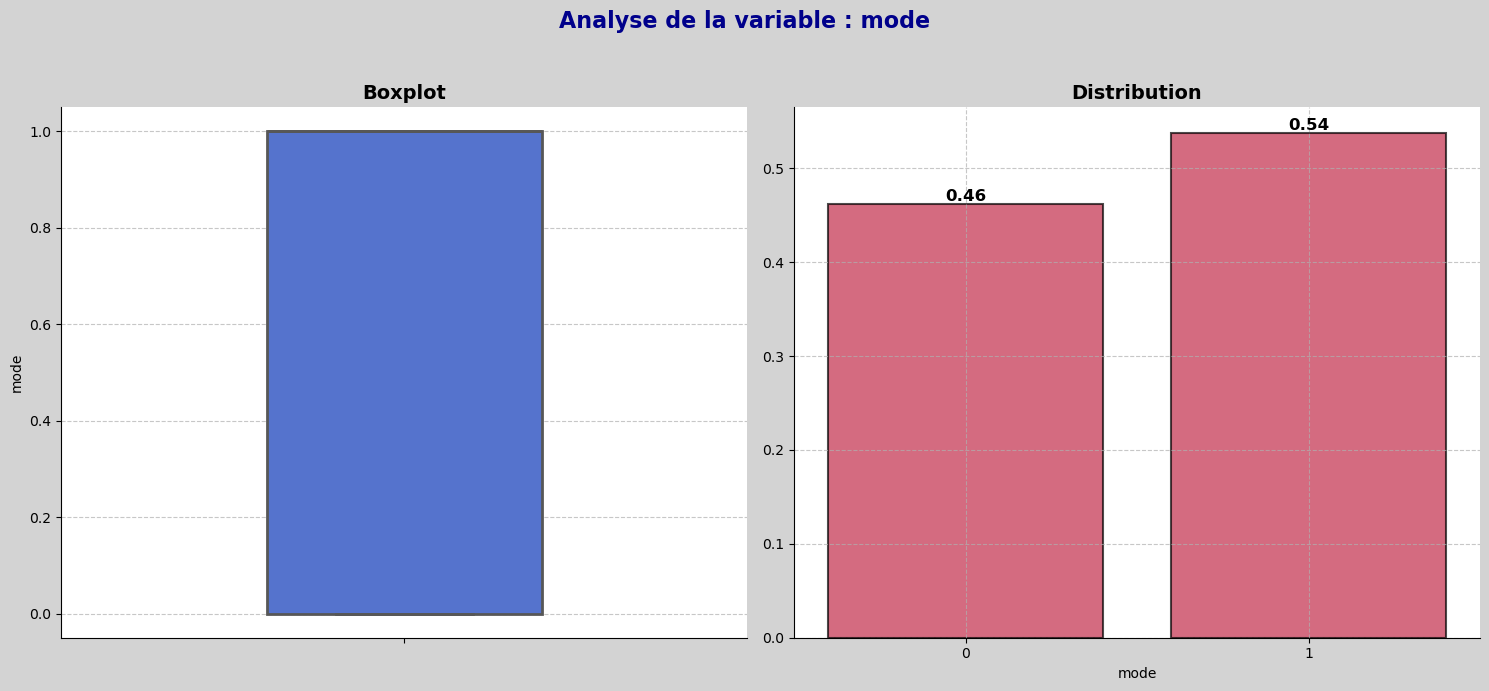

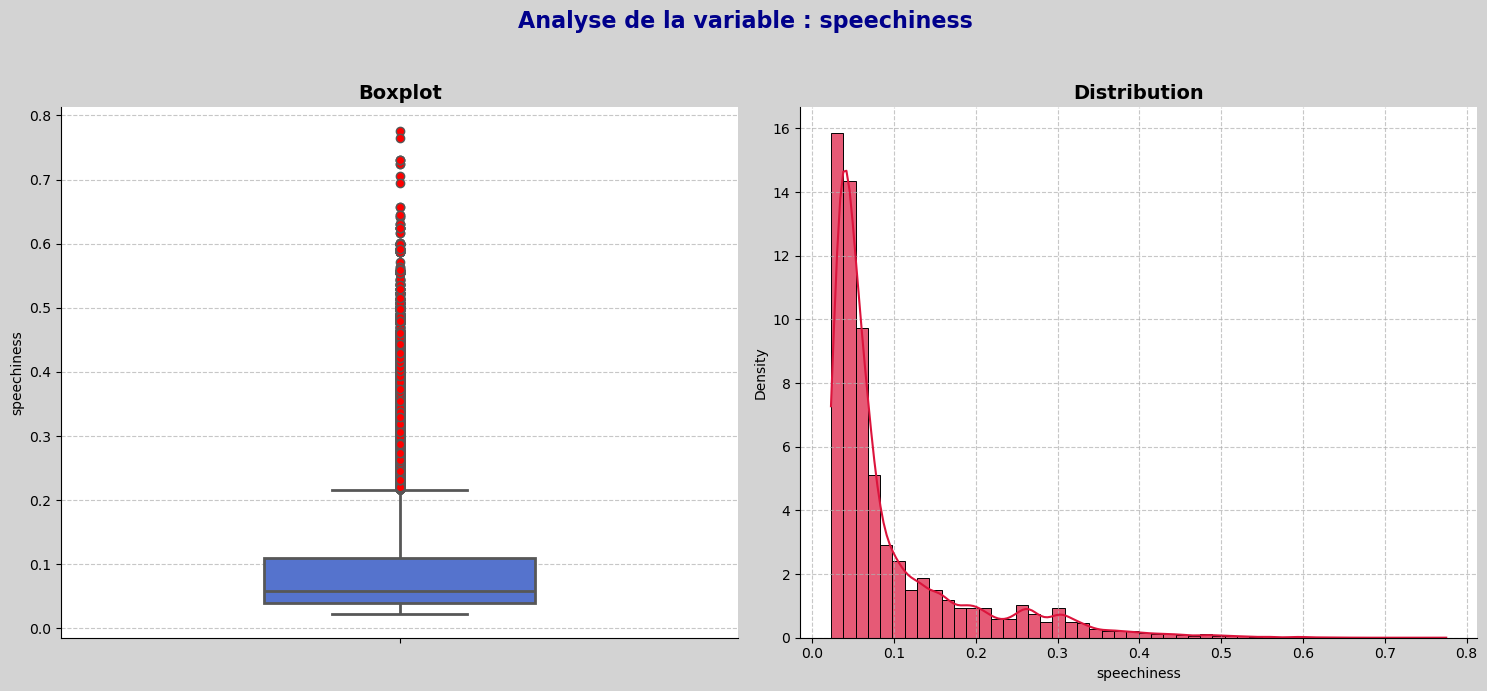

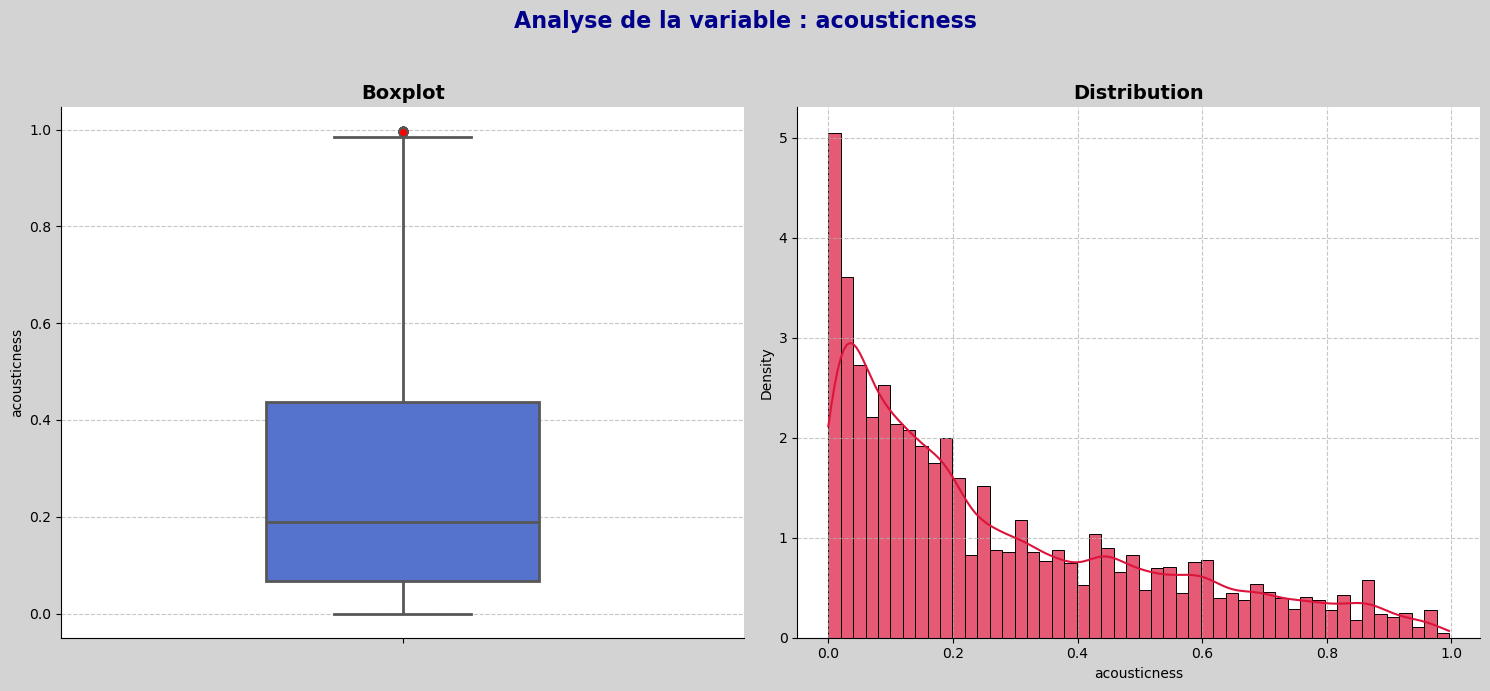

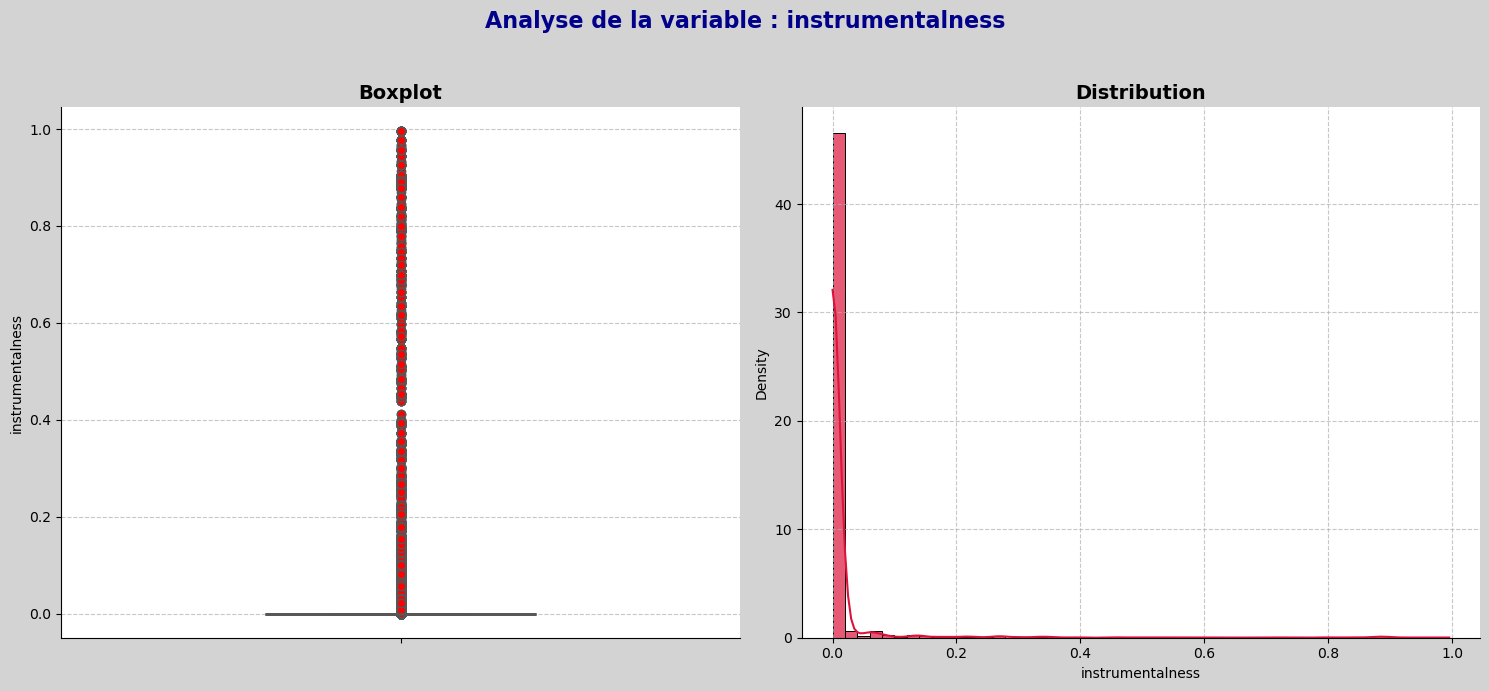

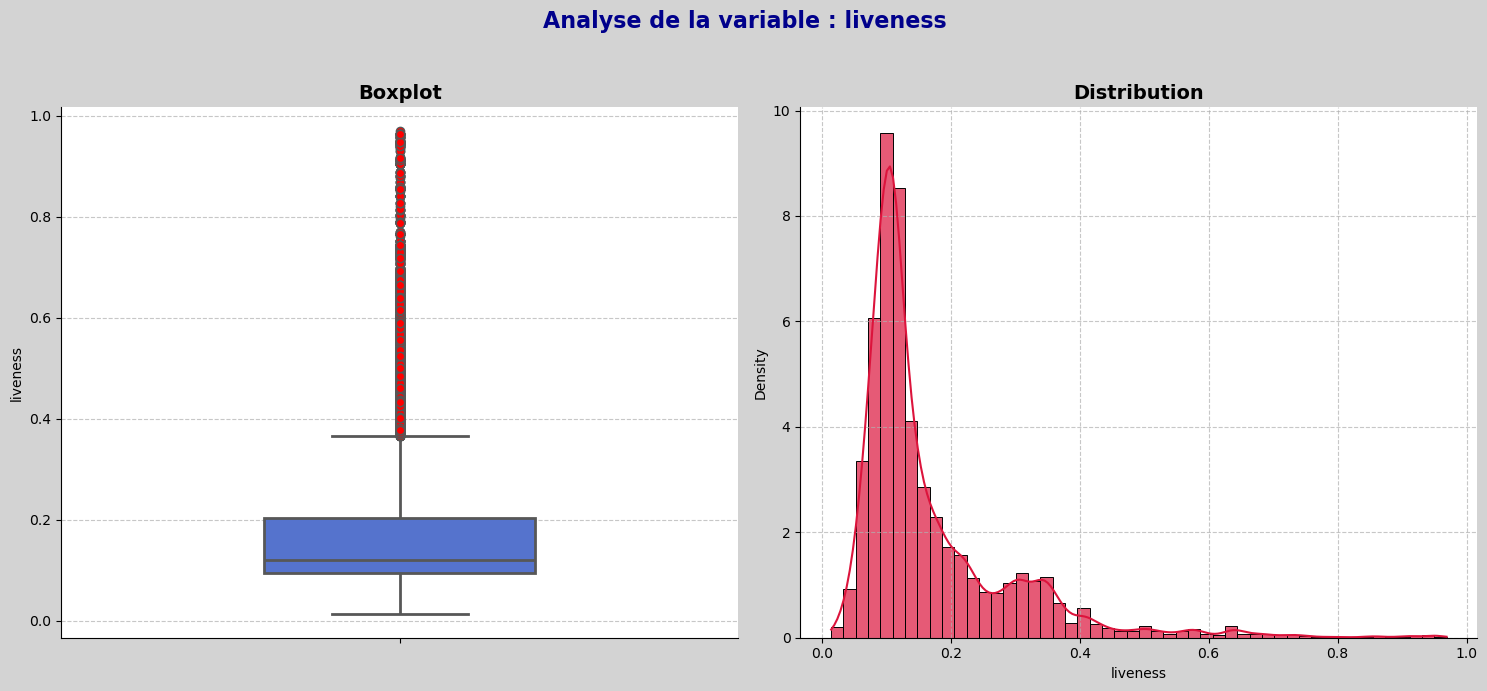

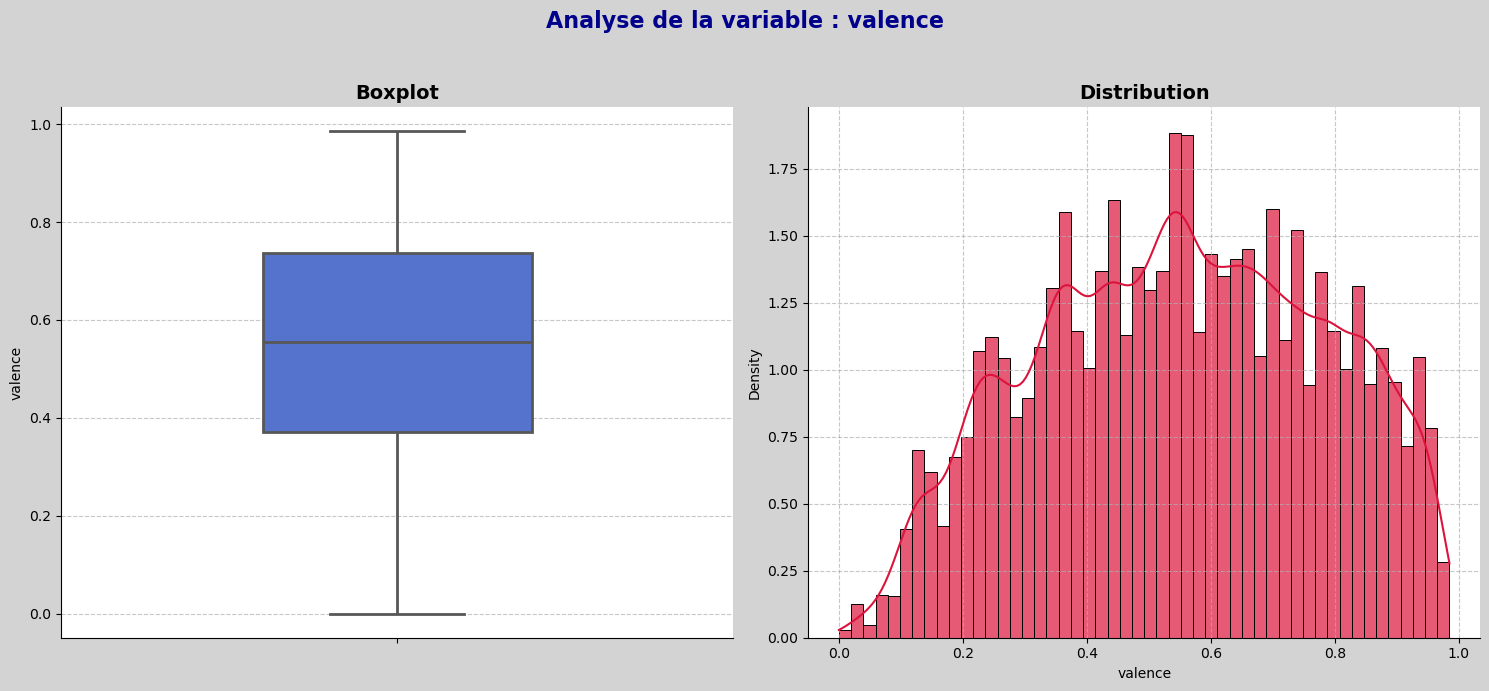

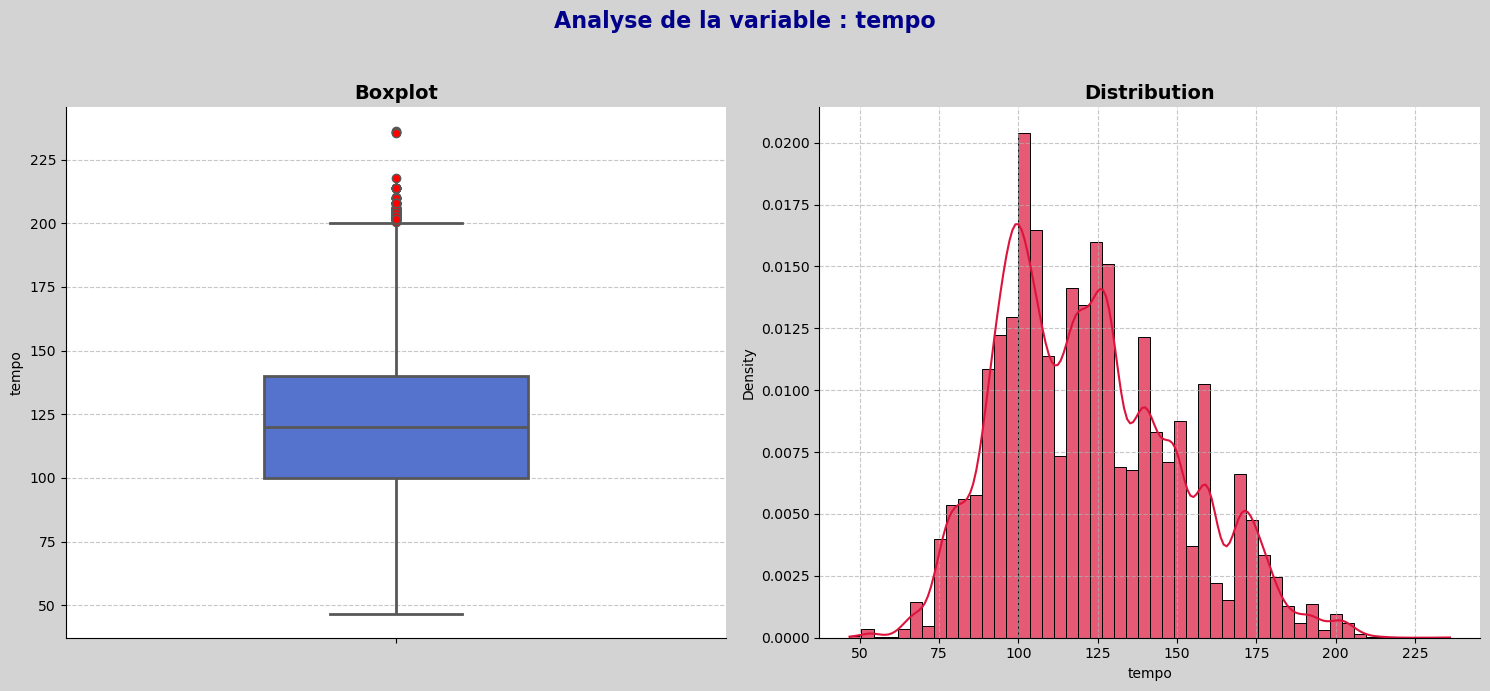

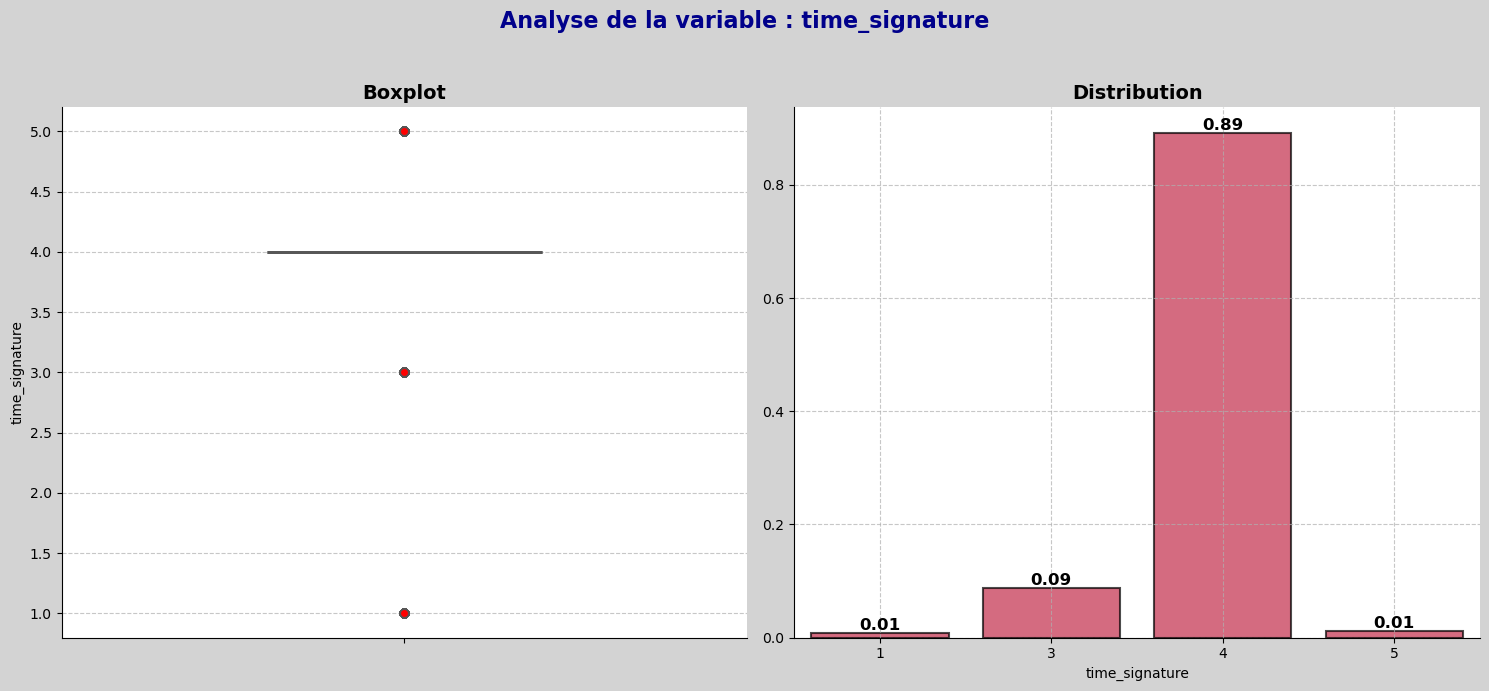

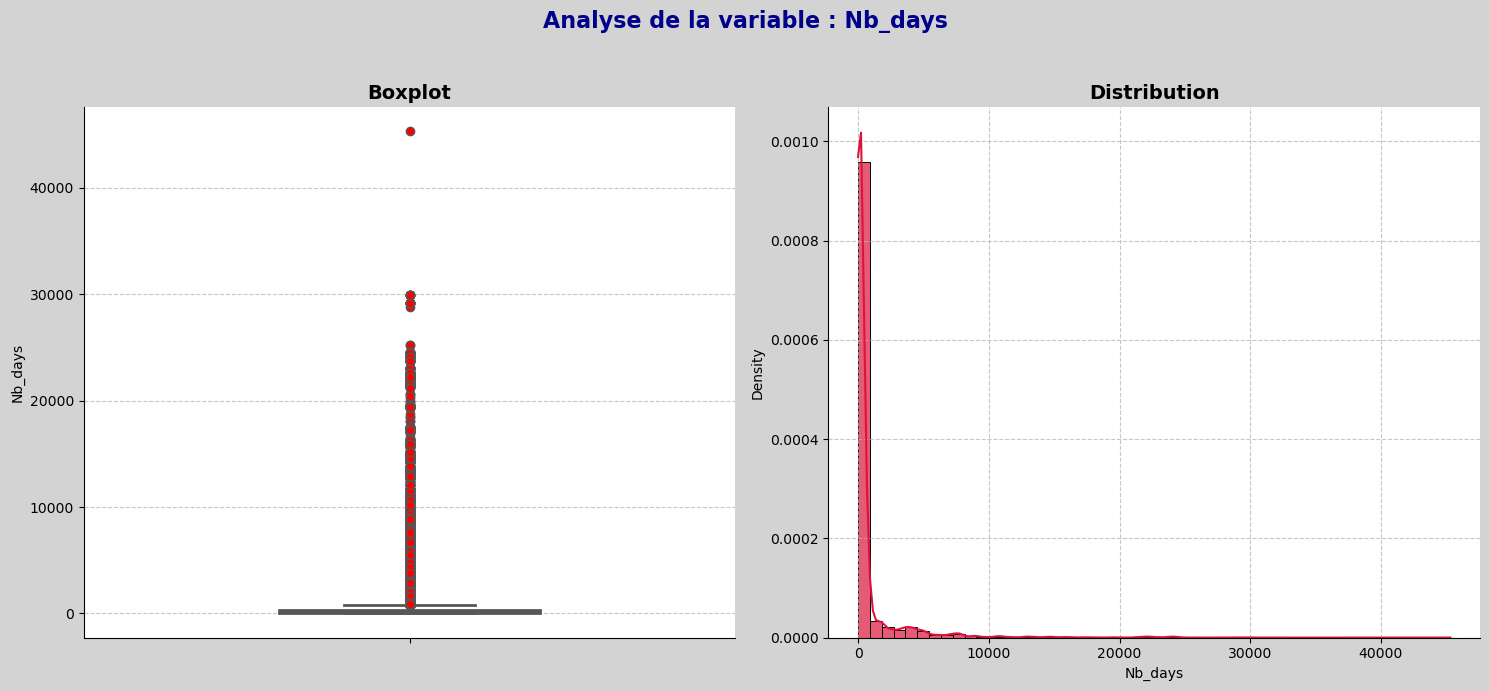

In [23]:
# Fixer la graine pour les résultats reproductibles
np.random.seed(42)

N_experience = 50000  # Nombre d'échantillons

# Sélection des variables quantitatives
Base_numeric = Base.select_dtypes(include=['int64', 'float64'])
Name_Base_num = Base_numeric.columns
n_num, p_num = Base_numeric.shape

# Couleurs personnalisées
box_color = "royalblue"
hist_color = "crimson"

# Création de la visualisation pour chaque variable
for i in range(p_num):
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))  # 1 ligne, 2 colonnes
    fig.patch.set_facecolor('lightgray')
    
    
    # Échantillonnage pour éviter de traiter trop de données
    sample_data = Base_numeric.iloc[:, i].sample(n=N_experience, random_state=42)

    # Titre principal
    fig.suptitle(f"Analyse de la variable : {Name_Base_num[i]}", fontsize=16, fontweight='bold', color="darkblue")

    # **Boxplot**
    sns.boxplot(y=sample_data, width=0.4, linewidth=2, color=box_color,
                flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 6}, ax=axes[0])
    
    axes[0].set_title("Boxplot", fontsize=14, fontweight='bold')
    axes[0].grid(axis="y", linestyle="--", alpha=0.7)  # Grille légère

    # **Histogramme ou Barplot**
    data_num_type = sample_data.dtype
    if np.issubdtype(data_num_type, np.integer) and len(np.unique(sample_data)) <= 15:
        # Barplot pour données discrètes
        int_counts = sample_data.value_counts().sort_index()
        
        # Normaliser les données pour obtenir des densités
        total_count = int_counts.sum()
        normalized_counts = int_counts / total_count  # Convertir en densité

        sns.barplot(x=normalized_counts.index, y=normalized_counts.values, ax=axes[1],  
                    color=hist_color, alpha=0.7, edgecolor="black", linewidth=1.5)

        # Ajout des valeurs sur les barres
        for p in axes[1].patches:
            axes[1].annotate(f'{p.get_height():.2f}', 
                             (p.get_x() + p.get_width() / 2., p.get_height()),  
                             ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')
        
    else:
        # Histogramme avec courbe KDE pour données continues
        sns.histplot(sample_data, kde=True, bins=50, stat="density", ax=axes[1], 
                     color=hist_color, alpha=0.7, edgecolor="black")
        
    axes[1].set_title("Distribution", fontsize=14, fontweight='bold')
    axes[1].grid(axis="x", linestyle="--", alpha=0.7)  # Grille pour l'axe x
    axes[1].grid(axis="y", linestyle="--", alpha=0.7)  # Grille pour l'axe y

    # Ajustements finaux
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajuster la disposition pour éviter le chevauchement avec le titre
    sns.despine()
    plt.show()

On peut observer que la présence majeur d'Outlier sur la plupart des Boxplots tels que sur les variables instrumentalness, ou encore duration_ms. De plus, on repère des asymétries sur un bon nombre de variables, ce qui suggère d'utiliser des transformations sur les données (log, racine carrée) ou des techniques de regression alternative.

# **3 - ACP et analyse**
---
## 3.1 - ACP
---

On réalise une ACP sur les variables quantitatives afin d'observer les possibles corrélations entre elles. Cela nous permet d'estimer les variables les plus intéressantes pour la régression linéaire.

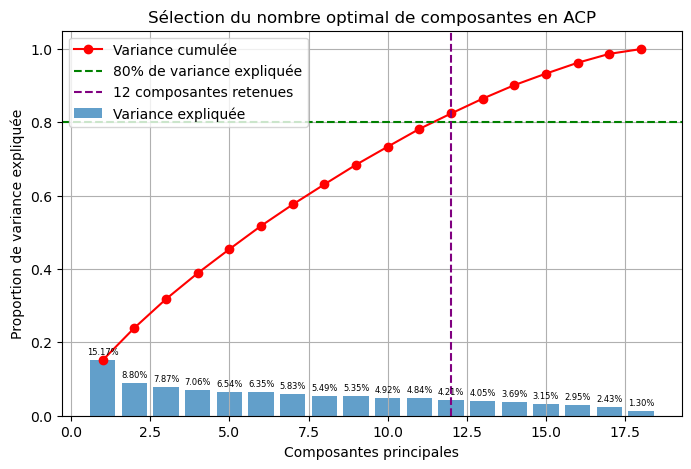

In [27]:
X = Base_numeric.to_numpy()

# Centrer les données et réduire les données
X_mean = np.nanmean(X, axis=0)
X_ecart_type = np.nanstd(X, axis=0)
X_centered_reduced = (X - X_mean) / X_ecart_type

# Matrice de corrélation
corr_matrix = pd.DataFrame(X_centered_reduced).corr()
valeurs_propres, vecteurs_propres = np.linalg.eig(corr_matrix)

# Tri des valeurs propres et des vecteurs propres et selon la base
indices_triees = np.argsort(valeurs_propres)[::-1]  # Tri décroissant des indices des valeurs propres
valeurs_propres_triees = valeurs_propres[indices_triees]  # Valeurs propres triées
vecteurs_propres_triees = vecteurs_propres[:, indices_triees]  # Vecteurs propres associés triés
Base_numeric_triee = Base_numeric.iloc[:, indices_triees]

# Calcul de la variance expliquée
variance_expliquee = valeurs_propres_triees / np.sum(valeurs_propres_triees)
variance_cumulee = np.cumsum(variance_expliquee)

# Déterminer le nombre de composantes pour atteindre 80% de variance expliquée
seuil = 0.80 
nb_composantes = np.argmax(variance_cumulee >= seuil) + 1  # Première valeur dépassant le seuil

# Création du graphique
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(valeurs_propres) + 1), variance_expliquee, alpha=0.7, label="Variance expliquée")
plt.plot(range(1, len(valeurs_propres) + 1), variance_cumulee, marker='o', linestyle='-', color='red', label="Variance cumulée")

# Ajout d'une ligne horizontale pour le seuil
plt.axhline(y=seuil, color='green', linestyle='--', label=f"{int(seuil * 100)}% de variance expliquée")

# Annotation pour le nombre optimal de composantes
plt.axvline(x=nb_composantes, color='purple', linestyle='--', label=f"{nb_composantes} composantes retenues")

# Ajouter les pourcentages de variance expliquée sur les barres
for i, v in enumerate(variance_expliquee):
    plt.text(i + 1, v + 0.01, f"{v*100:.2f}%", ha='center', va='bottom', fontsize=6, color='black')

plt.xlabel("Composantes principales")
plt.ylabel("Proportion de variance expliquée")
plt.title("Sélection du nombre optimal de composantes en ACP")
plt.legend()
plt.grid()

# Affichage du graphique
plt.show()

## 3.2 - Matrice de corrélation
---

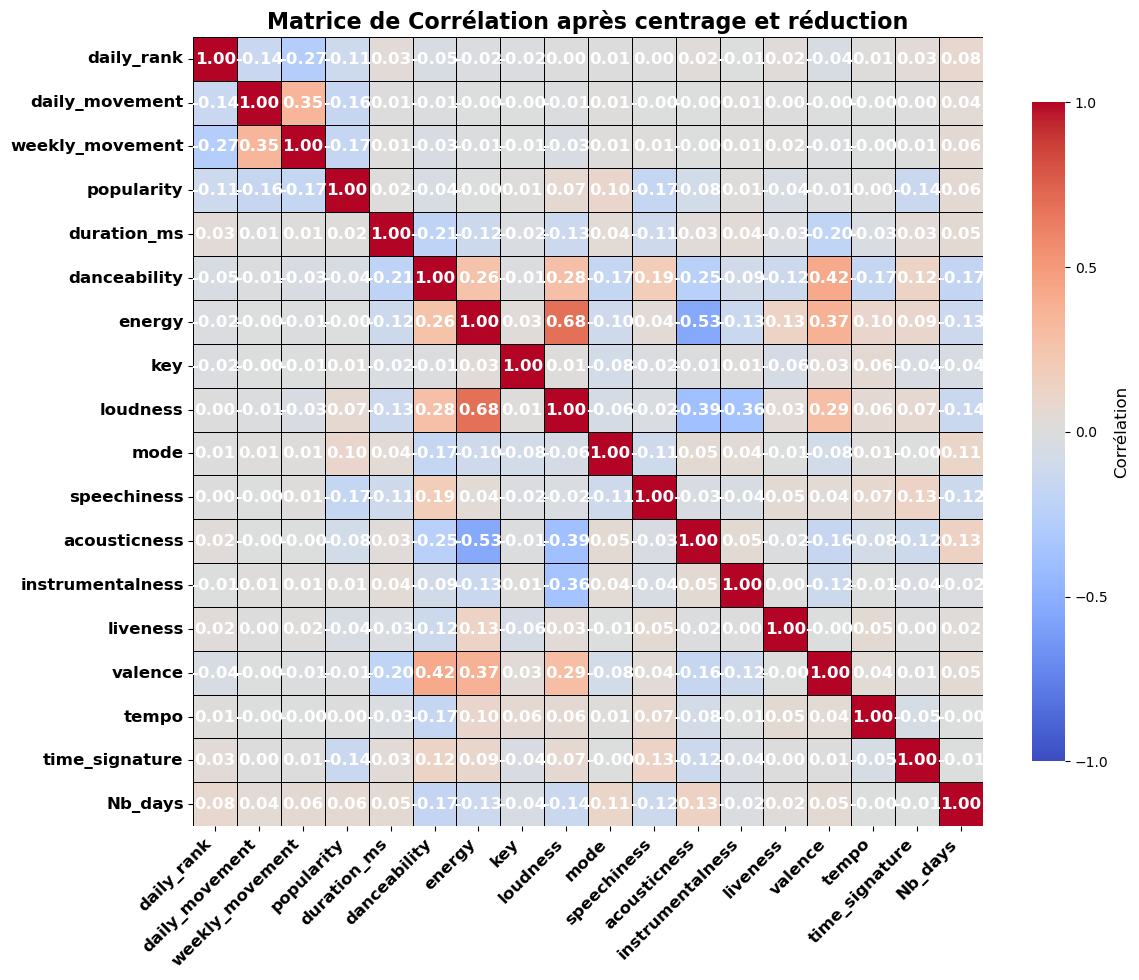

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Création de la figure pour afficher la heatmap
plt.figure(figsize=(12, 10))  # Taille de la figure

# Affichage de la heatmap avec des améliorations esthétiques
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, 
                      vmin=-1, vmax=1, cbar_kws={"shrink": 0.8, "label": "Corrélation"}, 
                      square=True, xticklabels=Base_numeric.columns, 
                      yticklabels=Base_numeric.columns, 
                      annot_kws={"size": 12, "weight": "bold", "color": "white"},  # Style des annotations
                      linecolor='black', linewidth=0.7)  

# Ajustement des labels des axes pour qu'ils soient bien lisibles
plt.xticks(rotation=45, ha='right', fontsize=12, color="black", fontweight='bold')
plt.yticks(rotation=0, ha='right', fontsize=12, color="black", fontweight='bold')

# Personnaliser la barre de couleur
cbar = heatmap.collections[0].colorbar
cbar.set_ticks([-1, -0.5, 0, 0.5, 1])  # Définir les ticks sur la barre de couleur
cbar.set_label('Corrélation', fontsize=12)

# Titre
plt.title('Matrice de Corrélation après centrage et réduction', fontsize=16, fontweight='bold')

# Ajuster l'espacement pour éviter les chevauchements
plt.tight_layout()

# Affichage
plt.show()


## 3.3 - Cercle de Corrélation
---

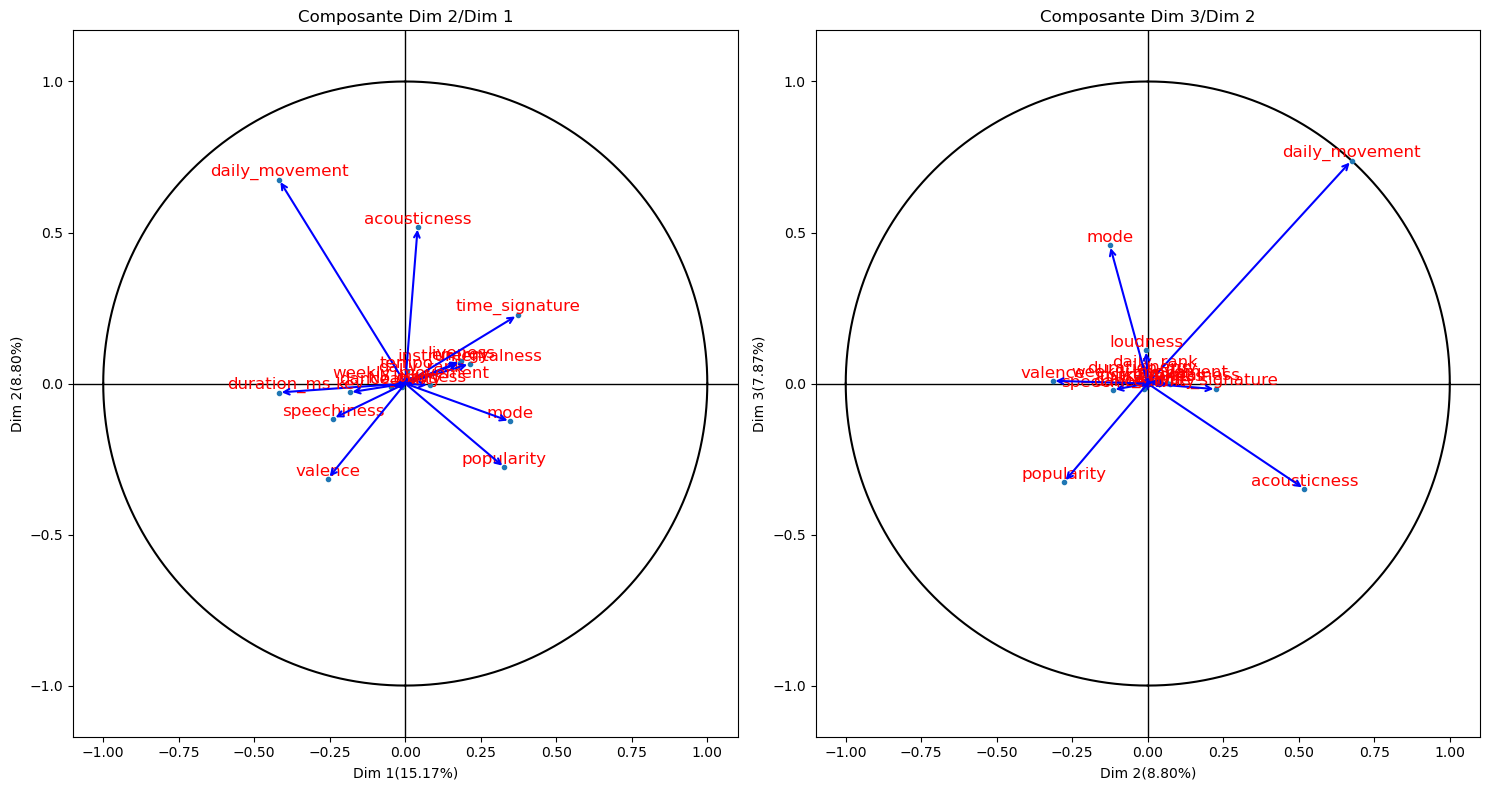

In [31]:
# Trier les colonnes de Base_numeric selon les indices triés des composantes principales
Base_numeric_triee = Base_numeric.iloc[:, indices_triees]  # Trier les colonnes de Base_numeric en fonction du tri des composantes

# Cercle de corrélation :
corr_matrix = pd.DataFrame(X_centered_reduced).corr().to_numpy()
coord = vecteurs_propres_triees[:, :len(corr_matrix)] * np.sqrt(valeurs_propres_triees[:len(corr_matrix)])

def cercle_ligne(nb_point):
    x = np.linspace(0, 1, nb_point)
    y = np.sqrt(1 - x**2)
    plt.plot(x, y, color="black")
    plt.plot(x, -y, color="black")
    plt.plot(-x, y, color="black")
    plt.plot(-x, -y, color="black")
    # Ajouter les lignes des axes
    plt.axhline(0, color='black', linewidth=1)  # Ligne horizontale (axe des ordonnées)
    plt.axvline(0, color='black', linewidth=1)  # Ligne verticale (axe des abscisses)

# Afficher les graphes pour chaque paire de composantes principales
plt.figure(figsize=(15, 8))  # Créer une grande figure pour deux sous-graphes
for idx, (i, j) in enumerate([(0, 1), (1, 2)]):  # Pour chaque paire de composantes
    plt.subplot(1, 2, idx+1)  # Créer deux sous-graphes côte à côte
    
    cercle_ligne(1000000)
    
    # Tracer les coordonnées
    plt.plot(coord[i], coord[j], ".")

    # Ajouter le texte pour chaque variable sur le cercle
    for idx_name, name in enumerate(Base_numeric_triee.columns):
        plt.text(coord[i, idx_name], coord[j, idx_name], name,
                 color='red', ha='center', va='bottom', fontsize=12)
        
        # Ajouter les flèches pointant vers les points
        plt.annotate("", xy=(coord[i, idx_name], coord[j, idx_name]), xytext=(0, 0), 
                     arrowprops=dict(arrowstyle="->", color="blue", lw=1.5))
    
    # Ajouter les annotations avec le pourcentage de variance expliquée sur les axes
    plt.xlabel(f"Dim {i+1}({100 * variance_expliquee[i]:.2f}%)")
    plt.ylabel(f"Dim {j+1}({100 * variance_expliquee[j]:.2f}%)")
    
    plt.title(f"Composante Dim {j+1}/Dim {i+1}")
    plt.axis('equal')

plt.tight_layout()  # Ajuste automatiquement la disposition des sous-graphes
plt.show()

## 3.4 - Matrice de composante principal
---

<Figure size 1000x1000 with 0 Axes>

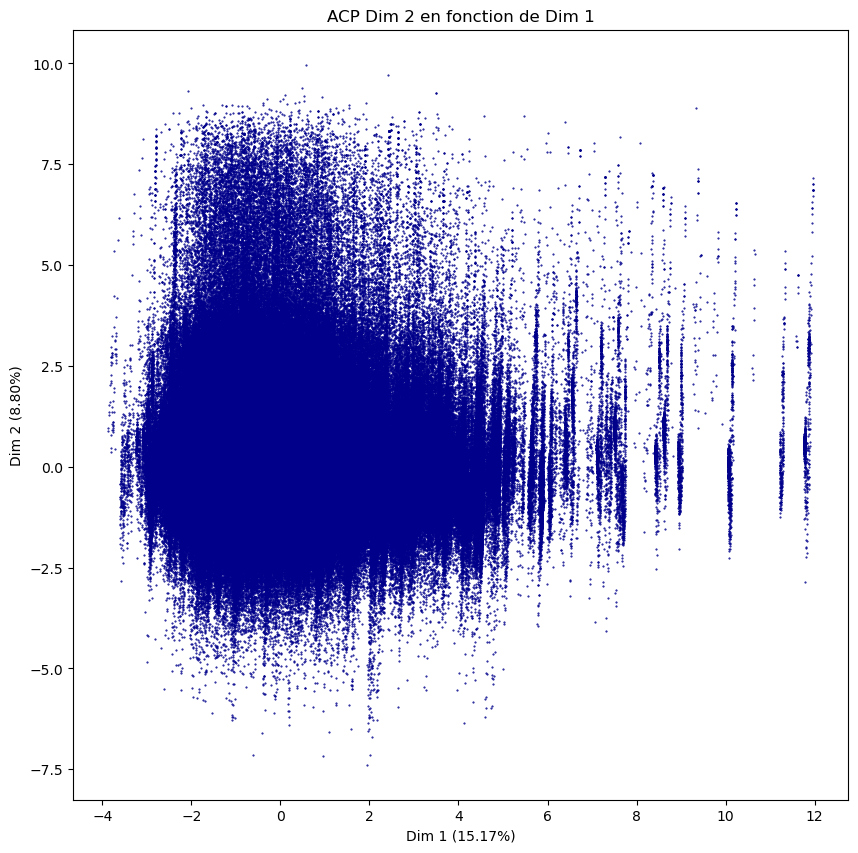

In [33]:
# Projeter les données dans l'espace des composantes principales
plt.rcParams['agg.path.chunksize'] = 1700000
X_projete = np.dot(X_centered_reduced, vecteurs_propres)

# Création du graphique
plt.figure(figsize=(10, 10))

for i, col_i in enumerate(Base_numeric_triee.columns):
    for j , col_j in enumerate(Base_numeric_triee.columns):
        if i == 0 and j == 1: 
            plt.figure(figsize=(10, 10))
            plt.plot(X_projete[:, i], X_projete[:, j], linestyle='', marker='o', markersize=0.5, color="darkblue", alpha=1)
            
            # Ajouter le pourcentage de variance expliquée pour les composantes principales
            plt.xlabel(f"Dim {i+1} ({variance_expliquee[i] * 100:.2f}%)")
            plt.ylabel(f"Dim {j+1} ({variance_expliquee[j] * 100:.2f}%)")
            
            plt.title(f"ACP Dim {j+1} en fonction de Dim {i+1}")
            plt.show()

# **4 - Régression multiple**
---

## Modèle de régression linéaire multiple

Le modèle de régression linéaire multiple est donné par l'équation suivante :

$$
Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_k X_k + \varepsilon
$$

Où :
- $Y$ est la variable dépendante (ou expliquée),
- $X_1, X_2, \dots, X_k$ sont les variables explicatives (ou indépendantes),
- $\beta_0$ est l'ordonnée à l'origine (intercept),
- $\beta_1, \beta_2, \dots, \beta_k$ sont les coefficients de régression associés à chaque variable explicative,
- $\varepsilon$ est l'erreur aléatoire (ou terme de perturbation).

### Matrice des variables explicatives $X$

La matrice $X$ est constituée de toutes les variables explicatives $X_1, X_2, \dots, X_k$, ainsi que d'une colonne de 1 pour l'intercept $\beta_0$. Elle se présente sous la forme :

$$
X = \begin{pmatrix}
1 & X_{11} & X_{12} & \cdots & X_{1k} \\
1 & X_{21} & X_{22} & \cdots & X_{2k} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & X_{n1} & X_{n2} & \cdots & X_{nk} \\
\end{pmatrix}
$$

### Estimation des coefficients $\beta$

Les coefficients $\beta_0, \beta_1, \dots, \beta_k$ sont estimés par la méthode des moindres carrés (MC), qui minimise la somme des carrés des résidus. L'estimation des coefficients $\hat{\beta}$ est donnée par :

$$
\hat{\beta} = (X^T X)^{-1} X^T Y
$$

Où :
- $X$ est la matrice des variables explicatives (de dimension $n \times (k+1)$, où $n$ est le nombre d'observations et $k$ est le nombre de variables explicatives),
- $Y$ est le vecteur des valeurs observées de la variable dépendante (de dimension $n \times 1$),
- $\hat{\beta}$ est le vecteur des coefficients estimés (de dimension $(k+1) \times 1$).

## 4.1 - Création du modèle

---

Nous échantillonnons notre modèle et afin d'avoir des résultats reproductibles et cohérents, nous avons choisi une seed pour fixer la génération aléatoire et garantir que les résultats restent constants à chaque exécution du modèle. On a donc pris ici la seed suivant : `np.random.seed(42)`

In [133]:
# Fixer la graine pour la reproductibilité
np.random.seed(42)

# Charger les données (Base_numeric doit être un DataFrame Pandas)
X = Base_numeric.to_numpy()
n, p_ = X.shape

# Définir Y comme la 5e colonne (popularity)
Y = X[:, 4]

# Supprimer la colonne 5 pour définir X_e
X_e = np.delete(X, 4, axis=1)

# Échantillonnage aléatoire
n_r = X.shape[0]
k = min(50000, n_r)
indices = np.random.choice(n_r, k, replace=False)

# Sous-échantillonnage
X_e = X_e[indices, :]
Y_e = Y[indices]  # Assurer qu'on garde les mêmes indices

# Ajouter une colonne de 1 pour l'intercept
X_e = np.hstack((np.ones((X_e.shape[0], 1)), X_e))

# Calcul des coefficients Beta (Régression linéaire)
Beta, _, _, _ = np.linalg.lstsq(X_e, Y_e, rcond=None)

# estimation
Y_r = X_e @ Beta

# Vérifier si tout est correct
print("Beta:\n", Beta, "\n")
print("Estimations Y_r:\n", Y_r[:10])  # Afficher les 10 premières estimation

Beta:
 [ 2.30793020e+05  7.10221218e+01  5.42230705e+01  1.09120581e+01
  6.39792285e+00 -5.38824076e+04 -5.79846816e+03 -2.40310236e+02
 -1.02495203e+03 -1.14905604e+03 -4.29299954e+04 -1.30706475e+04
 -1.16664251e+04 -1.32682913e+04 -2.54507293e+04 -6.11167545e+01
  6.79339613e+03  3.97895410e-01] 

Estimations Y_r:
 [192630.94584236 185117.37088657 187408.67344509 181598.71931939
 192223.56476742 181371.87557442 185283.91814212 172700.52422892
 207531.2638489  170112.8319698 ]


## Plan d'hypothèse:
1 - Significativité du modèle (Test F, R ajusté, test student)

2 - Linéarité du modèle (Rainbow, Ramsey)

3 - Multicolinéarité (VIF)

4 - Homoscédasticité (Breusch-Pagan, )

5 - Normalité des résidus (Q-Q plot & Jarque-Bera)

6 - Indépendance des résidus (Durbin-Watson)

7 - Transformation du modèle (Box-Cox)

## 4.2 - Significativité des Beta
---

## Hypothèses du test t pour chaque coefficient $\beta_i $ :

Les hypothèses testées sont :

$$
H_{0,i} : \beta_i = 0 \quad \text{(pas d'effet de la variable explicative correspondante)}
$$
$$
H_{1,i} : \beta_i \neq 0 \quad \text{(l'effet de la variable explicative correspondante est significatif)}
$$

## Calcul de la statistique t

La statistique $ t_i $ pour chaque coefficient $ \beta_i $ est calculée comme suit :

$$
t_i = \frac{\hat{\beta_i}}{SE(\hat{\beta_i})}
$$

Où :
- $\hat{\beta_i}$ est l'estimation du coefficient $\beta_i$,
- $SE(\hat{\beta_i})$ est l'erreur standard de $\hat{\beta_i}$, qui peut être calculée comme :

$$
SE(\hat{\beta_i}) = \sqrt{\hat{\sigma}^2 \cdot (X^T X)^{-1}_{ii}}
$$

Où :
- $\hat{\sigma}^2$ est l'estimation de la variance des résidus, donnée par :

$$
\hat{\sigma}^2 = \frac{1}{n-k} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

### Hypothèses du test de Fisher :

$$
H_0 : \beta_1 = \beta_2 = ... = \beta_p = 0 \quad \text{(le modèle n'a aucun pouvoir explicatif)}
$$

$$
H_1 : \exists \, i, \quad \beta_i \neq 0 \quad \text{(au moins une variable explicative a un effet significatif)}
$$

### Statistique du test de Fisher :

$$
F = \frac{\text{SSR} / p}{\text{SSE} / (n - p - 1)}
$$

où :
- $ SSR $ est la somme des carrés expliquée (Sum of Squares for Regression),
- $ SSE $ est la somme des carrés des erreurs (Sum of Squares for Error),
- $ p $ est le nombre de variables explicatives,
- $ n $ est le nombre d'observations.

#### Interprétation selon la p-value :

- **Si $ p\text{-value} < 0.05 $** (seuil de signification de 5%) :
  - On **rejette $ H_0 $**.
  - Le modèle a une **capacité explicative significative**, c'est-à-dire qu'au moins une variable explicative influence significativement la variable dépendante.

- **Si $ p\text{-value} \geq 0.05 $** :
  - On **ne rejette pas $ H_0 $**.
  - Il n'y a **pas suffisamment de preuves** pour affirmer que le modèle explique significativement la variable dépendante.

#### Avec la formule de $R_{adj}^2$ suivante :
$$
R_{adj}^2 = 1 - \left( \frac{(1 - R^2) \times (n - 1)}{n - p - 1} \right)
$$

où :
- $ R^2 $ : le coefficient de détermination classique.
- $ n $ : le nombre total d'observations.
- $ p $ : le nombre de variables explicatives (sans inclure la constante).

In [174]:
# Régression avec statsmodels
model = sm.OLS(Y_e, X_e).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     253.1
Date:                Fri, 21 Mar 2025   Prob (F-statistic):               0.00
Time:                        01:41:29   Log-Likelihood:            -6.0885e+05
No. Observations:               50000   AIC:                         1.218e+06
Df Residuals:                   49982   BIC:                         1.218e+06
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.308e+05   3636.384     63.468      0.0

Quelles variables rejète ou accepte-t-on ?
- X1 - daily_rank : Rejetée
- X2 - daily_movement : **Acceptée**
- X3 - weekly_movement : **Acceptée**
- X4 - duration_ms : **Acceptée**
- X5 - danceability : Rejetée
- X6 - energy : Rejetée
- X7 - key : Rejetée
- X8 - loudness : Rejetée
- X9 - mode : Rejetée
- X10 - speechiness : Rejetée
- X11 - acousticness : Rejetée
- X12 - instrumentalness : Rejetée
- X13 - liveness : Rejetée
- X14 - valence : Rejetée
- X15 - tempo : Rejetée
- X16 - time_signature : Rejetée
- X17 - Nb_days : Rejetée

On peut observer que le modèle est statistiquement significatif car la Prob (F-statistic) = 0 est proche de 0. Cela signifie qu'au moins une des variables explicatives a un effet sur la variable cible Y. 

Cependant, le R² est très faible (0.077). En effet, le modèle n'explique que 7,9% de la variance de la variable cible Y. Il manque probablement des variables importantes, ou alors la relation entre X et Y est non linéaire.

## 4.3 - Test de linéarité
---

Le test de Rainbow consiste à étendre ce modèle en introduisant des termes non linéaires de $X$, par exemple des termes quadratiques ou cubiques. Un modèle polynomiale de degré 2, par exemple, serait :

$$
y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_k X_k + \gamma_1 X_1^2 + \gamma_2 X_2^2 + \cdots + \gamma_k X_k^2 + \varepsilon
$$

L'objectif est de tester si les coefficients des termes quadratiques $ \gamma_1, \gamma_2, \dots, \gamma_k $ sont significativement différents de zéro.

### Hypothèses du test de Rainbow

Les hypothèses à tester dans le cadre du test de Rainbow sont :

**Hypothèse nulle $ H_0 $** : Le modèle est linéaire, c'est-à-dire que les coefficients des termes quadratiques sont égaux à zéro (les variables explicatives n'ont pas d'effet non linéaire) :
$$
H_0 : \gamma_1 = \gamma_2 = \cdots = \gamma_k = 0
$$

**Hypothèse alternative $ H_1 $** : Le modèle n'est pas linéaire, c'est-à-dire que les coefficients des termes quadratiques sont significativement différents de zéro :
$$
H_1 : \text{Au moins un} \ \gamma_i \neq 0 \text{ pour } i \in \{1, 2, \dots, k\}
$$



In [47]:
# Ajustement du modèle
rainbow_stat, rainbow_p_value = linear_rainbow(model)
print(f"Rainbow test: Stat={rainbow_stat}, p-value={rainbow_p_value}")
if rainbow_p_value < 0.05:
    print(f"la relation n'est pas linéaire avec un p_value = {rainbow_p_value}")
else:
    print(f"la relation est linéaire avec un p_value = {rainbow_p_value}")


Rainbow test: Stat=1.0042991081669388, p-value=0.36727486414813726
la relation est linéaire avec un p_value = 0.36727486414813726


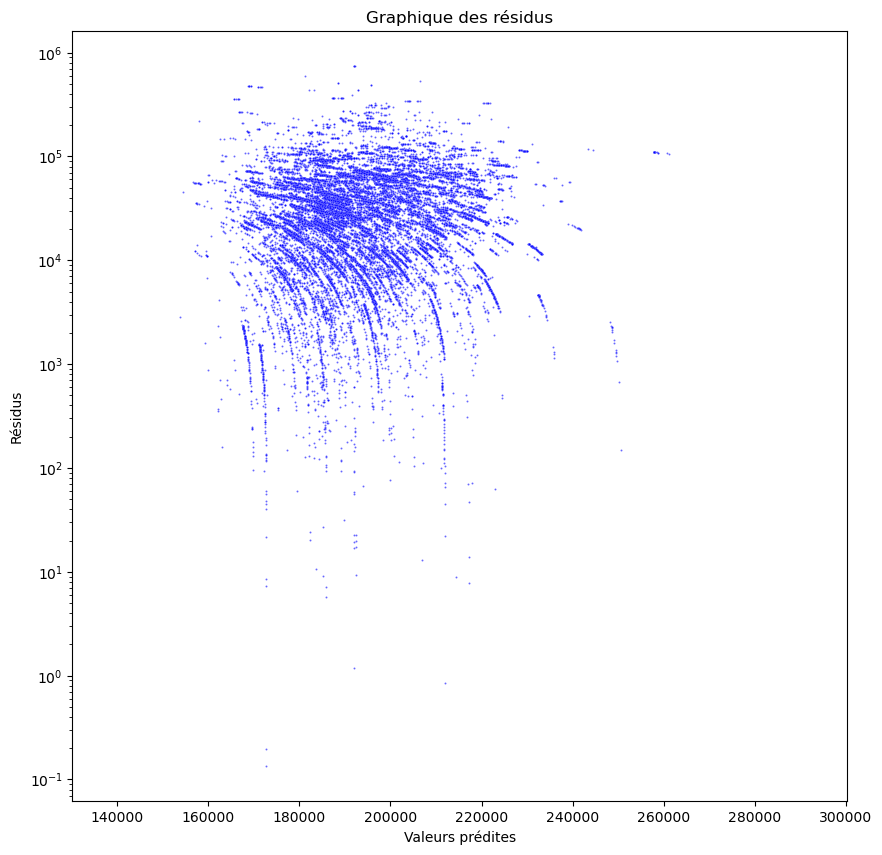

In [48]:
# Résidus du modèle
residuals = model.resid

# Graphique des résidus
plt.figure(figsize=(10, 10))
sns.scatterplot(x=model.fittedvalues, y=residuals, color='blue', alpha=0.6, s=2)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.title('Graphique des résidus')
plt.yscale('log')
plt.savefig('Graphique_residus.png', dpi=300)
plt.show()

## Test de Ramsey (linéarité)

Le **test de Ramsey RESET** est utilisé pour tester la spécification du modèle. Il permet de vérifier si des termes non linéaires ou d'interaction sont nécessaires dans un modèle de régression linéaire multiple. Si des termes supplémentaires sont significatifs, cela pourrait indiquer que le modèle est mal spécifié et que certains termes non linéaires ou d'interaction doivent être ajoutés pour améliorer la qualité de la prédiction.

## Hypothèses du Test de Ramsey (RESET)

### Hypothèse nulle $ H_0 $ :
Le modèle est bien spécifié et il n'est pas nécessaire d'ajouter des termes polynomiaux ou d'interaction supplémentaires :
$$
H_0 : \gamma_1 = \gamma_2 = \dots = \gamma_{k-1} = 0
$$
Les termes polynomiaux et d'interaction ne sont pas significatifs.

### Hypothèse alternative $ H_1 $ :
Le modèle est mal spécifié et il est nécessaire d'ajouter des termes polynomiaux ou d'interaction :
$$
H_1 : \text{Au moins un} \ \gamma_i \neq 0, \ \text{pour} \ i \in \{1, 2, \dots, k-1\}
$$
Cela suggère que le modèle ne capture pas correctement la relation entre les variables et nécessite des termes supplémentaires pour être mieux spécifié.

## Modèle de Régression Linéaire Multiple

Dans un modèle de régression linéaire multiple, la forme générale du modèle est :
$$
Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_n X_n + \varepsilon
$$
Cependant, le test de Ramsey RESET consiste à tester l'ajout de termes polynomiaux (ou non linéaires) dans la régression, comme $ X_1^2, X_1^3, X_2^2, X_1 \cdot X_2 $, etc.

### Calcul de la statistique de test RESET

La statistique du test de Ramsey RESET est généralement une statistique de type F qui compare la régression de base avec la régression augmentée (modèle avec des termes supplémentaires). La statistique F est calculée comme suit :
$$
F = \frac{(\text{RSS}_1 - \text{RSS}_2) / m}{\text{RSS}_2 / (n - k)}
$$
Où :
- $ \text{RSS}_1 $ est la somme des carrés des résidus pour le modèle de régression de base.
- $ \text{RSS}_2 $ est la somme des carrés des résidus pour le modèle avec des termes polynomiaux supplémentaires.
- $ m $ est le nombre de nouveaux termes ajoutés (termes polynomiaux ou d'interaction).
- $ n $ est le nombre d'observations.
- $ k $ est le nombre de paramètres dans le modèle de régression (y compris l'ordonnée à l'origine).

### Interprétation des résultats

- Si la statistique F est significative (c'est-à-dire que le test est rejeté), cela suggère que des termes supplémentaires sont nécessaires et que le modèle est mal spécifié.
- Si la statistique F n'est pas significative, le modèle de régression est bien spécifié et il n'est pas nécessaire d'ajouter des termes polynomiaux ou d'interaction.


In [50]:
# Test de Ramsey RESET
reset_test = linear_reset(model, power=2, use_f=True)  # Test avec Y^2

# Accéder aux résultats avec l'objet ContrastResults
print(f"Statistique F: {reset_test.fvalue:.4f}")
print(f"P-valeur: {reset_test.pvalue:.4f}")

# Interprétation des résultats
alpha = 0.05
if reset_test.pvalue < alpha:
    print("Le modèle est mal spécifié (il manque des variables ou des non-linéarités).")
else:
    print("On ne rejette pas l'hypothèse que le modèle est bien spécifié.")
    

Statistique F: 8.4971
P-valeur: 0.0036
Le modèle est mal spécifié (il manque des variables ou des non-linéarités).


## 4.3 - Analyse de la multicolinéarité
---

### VIF (Variance Inflation Factor)

Le **VIF** (Variance Inflation Factor) mesure à quel point la variance (ou l'incertitude) d'un coefficient estimé est augmentée en raison de la colinéarité avec les autres variables. Le VIF d'une variable $X_i$ est défini comme suit :

$$
VIF_i = \frac{1}{1 - R_i^2}
$$

Où $R_i^2$ est le coefficient de détermination obtenu en régressant la variable $X_i$ contre toutes les autres variables explicatives. Un VIF élevé signifie que la variable $X_i$ est fortement corrélée avec les autres variables et peut donc induire de la multicolinéarité.

Le $ R_i^2 $ est défini comme suit :

$$
R_i^2 = 1 - \frac{\sum (X_i - \hat{X}_i)^2}{\sum (X_i - \bar{X}_i)^2}
$$

où :

- $ X_i $ : les valeurs observées de la variable explicative $ X_i $,
- $ \hat{X}_i $ : les valeurs prédites de $ X_i $ par la régression utilisant les autres variables explicatives,
- $ \bar{X}_i $ : la moyenne des $ X_i $.



In [144]:
# Vérification de la multicolinéarité (VIF)
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = range(X.shape[1])
    vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    return vif_data

vif_df = calculate_vif(X_e)
print("\nVariance Inflation Factors :\n", vif_df)


Variance Inflation Factors :
     Variable         VIF
0          0  299.066328
1          1    1.140917
2          2    1.166794
3          3    1.257727
4          4    1.159432
5          5    1.537265
6          6    2.628434
7          7    1.019768
8          8    2.340530
9          9    1.061001
10        10    1.124936
11        11    1.501896
12        12    1.200356
13        13    1.060742
14        14    1.425804
15        15    1.091234
16        16    1.067523
17        17    1.124014


Les variables 1 à 17 dumodèle semblent bien séparées en termes de variabilité, ce qui signifie qu'elles ne sont pas fortement corrélées entre elles (pas de multicolinéarité sévère), et donc, tes estimations des coefficients seront fiables.

En conclusion, tes variables sont relativement colinéaire les unes des autres, à l'exception de la constante (qui est normalement exclue de l'analyse de VIF). Donc, il n'y a pas de problème majeur de multicolinéarité.

En résumé, il n'y a pas de soucis de multicolinéarité significative dans ce modèle, à part pour la constante qui est normale.

## 4.4 Homoscedasticité (Test de White)
---

### Test de White pour l'Hétéroscédasticité

Le **test de White** permet de vérifier la présence d'hétéroscédasticité dans un modèle de régression, tout en étant robuste aux spécifications incorrectes du modèle, comme les erreurs de spécification non linéaires.

### Hypothèses du test de White :

#### Hypothèse nulle $ H_0 $ :
Les erreurs sont **homoscédastiques**, c'est-à-dire que la variance des erreurs est constante pour toutes les observations.  
Cela signifie que la variance des erreurs ne dépend pas des variables explicatives. Autrement dit, les erreurs sont indépendantes de la variance.

$$
H_0 : \text{Les erreurs sont homoscédastiques} \quad (\text{la variance des erreurs est constante})
$$

Mathématiquement, c'est traduit par :

$$
\text{Cov}(\varepsilon_i, \varepsilon_j) = 0 \quad \forall \ i \neq j \quad \text{et} \quad \text{Var}(\varepsilon_i) = \sigma^2 \quad \forall \ i
$$

où $\sigma^2$ est une constante pour toutes les observations.

#### Hypothèse alternative $ H_1 $ :
Les erreurs sont **hétéroscédastiques**, ce qui signifie que la variance des erreurs varie en fonction des variables explicatives.

$$
H_1 : \text{Les erreurs sont hétéroscédastiques} \quad (\text{la variance des erreurs varie en fonction des variables explicatives})
$$

En termes de covariance, cela peut être exprimé comme suit :

$$
\text{Cov}(\varepsilon_i, \varepsilon_j) = 0 \quad \forall \ i \neq j \quad \text{et} \quad \text{Var}(\varepsilon_i) = \sigma_i^2 \quad \text{avec} \ \sigma_i^2 \neq \sigma_j^2 \quad \text{pour} \ i \neq j
$$

Et dans le cas d'une covariance utilisant la **fonction delta de Dirac**, cela peut être écrit comme :

$$
\text{Cov}(\varepsilon_i, \varepsilon_j) = \sigma^2 \delta_{ij}
$$

où $\delta_{ij}$ est le symbole de Kronecker, qui vaut 1 lorsque $i = j$ et 0 lorsque $i \neq j$.

### Processus du Test de White :

1. **Estimation du modèle** par les **Moindres Carrés Ordinaires (MCO)**, ce qui permet d'obtenir les résidus $ \hat{\varepsilon}_i $.
2. **Élévation au carré des résidus** : On élève les résidus au carré pour obtenir $ \hat{\varepsilon}_i^2 $.
3. **Estimation de l'équation de test** par les MCO :

$$
\hat{\varepsilon}_i^2 = \gamma_0 + \gamma_1 x_1 + \gamma_2 x_2 + \dots + \gamma_k x_k + \omega_i
$$

4. **Calcul de la statistique de test de White** :

$$
W = n \cdot R^2
$$

Où :
- $ n $ est le nombre d'observations,
- $ R^2 $ est le coefficient de détermination de l'équation estimée à l'étape précédente.

5. **Décision du test** :
   - Si $ W > \chi^2_{\alpha, k} $ (avec $ \alpha = 0.05 $ et $ k $ étant le nombre de variables explicatives), on rejette l'hypothèse nulle $ H_0 $, indiquant ainsi la présence d'hétéroscédasticité.
   - Si $ W \leq \chi^2_{\alpha, k} $, on ne rejette pas $ H_0 $, ce qui suggère que le modèle est homogène (homoscédastique).


In [149]:
white_test = het_white(model.resid, model.model.exog)
white_stat, white_pval, _, _ = white_test  # white_stat est la statistique de test, white_pval est la p-value

# Interprétation
if white_pval < 0.05:
    print(f"Hétéroscédasticité détectée (rejette H0) avec une p_value de {white_pval}")
else:
    print(f"Homocédasticité (on ne rejette pas H0) avec une p_value de {white_pval}")


Hétéroscédasticité détectée (rejette H0) avec une p_value de 0.0


## 4.5 Test de Normalité des résidus (Dessage du Q-Q plot & Test de Jarque-Bera)
---

Le **test de Shapiro-Wilk** est utilisé pour tester la normalité d'une variable aléatoire. Il vérifie si un échantillon suit une distribution normale.

### Hypothèses du Test de Shapiro-Wilk

- **Hypothèse nulle $ H_0 $** :
  L'échantillon suit une distribution normale.
  $$
  H_0 : \text{Les données suivent une distribution normale.}
  $$

- **Hypothèse alternative $ H_1 $** :
  L'échantillon ne suit pas une distribution normale.
  $$
  H_1 : \text{Les données ne suivent pas une distribution normale.}
  $$

### Statistique du Test de Shapiro-Wilk

La statistique de test est calculée à partir de l'écart entre la distribution empirique des données et la distribution normale théorique. Plus cette statistique est proche de 1, plus les données suivent une distribution normale.

La formule de la statistique de Shapiro-Wilk est assez complexe, mais elle implique principalement le calcul d'un coefficient de corrélation entre les quantiles théoriques de la distribution normale et les quantiles observés dans l'échantillon.

- **Statistique du test $W$** : Elle est proche de 1 lorsque les données suivent une distribution normale.

$$
W = \frac{\left( \sum_{i=1}^n a_i x_{(i)} \right)^2}{\sum_{i=1}^n (x_i - \bar{x})^2}
$$

### Où :
- $ x_1, x_2, \dots, x_n $ sont les observations de l'échantillon, ordonnées de manière croissante, c'est-à-dire $ x_{(1)} \leq x_{(2)} \leq \dots \leq x_{(n)} $.
- $ \bar{x} $ est la moyenne des observations de l'échantillon.
- $ a_i $ sont les coefficients associés à chaque observation dans la statistique de Shapiro-Wilk. Ces coefficients dépendent de la taille de l'échantillon $ n $ et sont calculés en fonction des quantiles théoriques de la distribution normale.

### Interprétation :
- Si $ W $ est proche de 1, cela suggère que les données suivent une distribution normale.
- Si $ W $ est beaucoup plus petit que 1, cela indique que les données s'écartent de la normalité.


### Interprétation des résultats

- **Si la p-value est inférieure à un seuil (généralement 0.05)** :
  On rejette l'hypothèse nulle, ce qui suggère que les données ne suivent pas une distribution normale.
  
- **Si la p-value est supérieure au seuil (généralement 0.05)** :
  On ne rejette pas l'hypothèse nulle, ce qui suggère que les données peuvent suivre une distribution normale.

---

In [153]:
# 1. Test de normalité des résidus avec le test de Shapiro-Wilk
shapiro_stat, shapiro_pval = shapiro(model.resid)

# 2. Interprétation
if shapiro_pval < 0.05:
    print(f"Les résidus ne suivent pas une distribution normale (rejette H0) avec une p_value de {shapiro_pval}")
else:
    print(f"Les résidus suivent une distribution normale (on ne rejette pas H0) avec une p_value de {shapiro_pval}")

Les résidus ne suivent pas une distribution normale (rejette H0) avec une p_value de 4.491051611909633e-97


C:\Users\elouan\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 50000.
  res = hypotest_fun_out(*samples, **kwds)


## Test de Normalité des résidus (Test de Jarque-Bera)

À la différence du test de Shapiro-Wilk, qui est particulièrement puissant pour des échantillons de petite taille (généralement $n < 50$), le test de Jarque-Bera est mieux adapté aux grands échantillons comme le nôtre ($n_\text{obs} > 1\,000\,000$). Le test de Jarque-Bera examine spécifiquement ces deux aspects, ce qui le rend particulièrement pertinent pour détecter des déviations spécifiques de la normalité, telles que l'asymétrie des données ou un excès de kurtosis, qui peuvent être invisibles dans un simple test de normalité.

Le **test de Jarque-Bera** permet de tester la normalité d'une distribution en utilisant deux moments statistiques : l'asymétrie (skewness) et l'aplatissement (kurtosis) de la distribution.

### 1. Hypothèses du test de Jarque-Bera :

- **Hypothèse nulle (H₀)** : Les données suivent une distribution normale, ce qui implique une asymétrie (skewness) de 0 et une kurtosis de 3 (kurtosis excédentaire = 0).

$$ 
H_0 : \text{Skewness} = 0 \quad \text{et} \quad \text{Kurtosis} = 3
$$

- **Hypothèse alternative (H₁)** : Les données ne suivent pas une distribution normale, c'est-à-dire qu'elles présentent soit une asymétrie différente de 0, soit une kurtosis différente de 3 (ou les deux).

$$ 
H_1 : \text{Skewness} \neq 0 \quad \text{ou} \quad \text{Kurtosis} \neq 3
$$

### 2. Formule du test de Jarque-Bera :

La statistique du test de Jarque-Bera $JB$ est donnée par :

$$
JB = \frac{n - k}{6} \left( S^2 + \frac{(K - 3)^2}{4} \right)
$$

Où :
- $n$ : Le nombre d'observations.
- $k$ : Le nombre de variables explicatives si les données proviennent des **résidus d'une régression linéaire**. Sinon, $k = 0$.
- $S$ : L'asymétrie (skewness) de l'échantillon testé.
- $K$ : La kurtosis de l'échantillon testé.

### 3. Calcul de l'Asymétrie (Skewness) et de la Kurtosis :

L'asymétrie (skewness) et la kurtosis sont calculées avec les formules suivantes :

#### Asymétrie (Skewness) :

$$
S = \frac{\hat{\mu}_3}{\hat{\sigma}^3} = \frac{\frac{1}{n} \sum_{i=1}^{n} (x_i - \bar{x})^3}{\left( \frac{1}{n} \sum_{i=1}^{n} (x_i - \bar{x})^2 \right)^{3/2}}
$$

Où :
- $\hat{\mu}_3$ est l'estimateur du troisième moment.
- $\bar{x}$ est la moyenne de l'échantillon.
- $\hat{\sigma}^2$ est la variance de l'échantillon.

#### Kurtosis :

$$
K = \frac{\hat{\mu}_4}{\hat{\sigma}^4} = \frac{\frac{1}{n} \sum_{i=1}^{n} (x_i - \bar{x})^4}{\left( \frac{1}{n} \sum_{i=1}^{n} (x_i - \bar{x})^2 \right)^2}
$$

Où :
- $\hat{\mu}_4$ est l'estimateur du quatrième moment.
- $\bar{x}$ et $\hat{\sigma}^2$ sont respectivement la moyenne et la variance de l'échantillon.


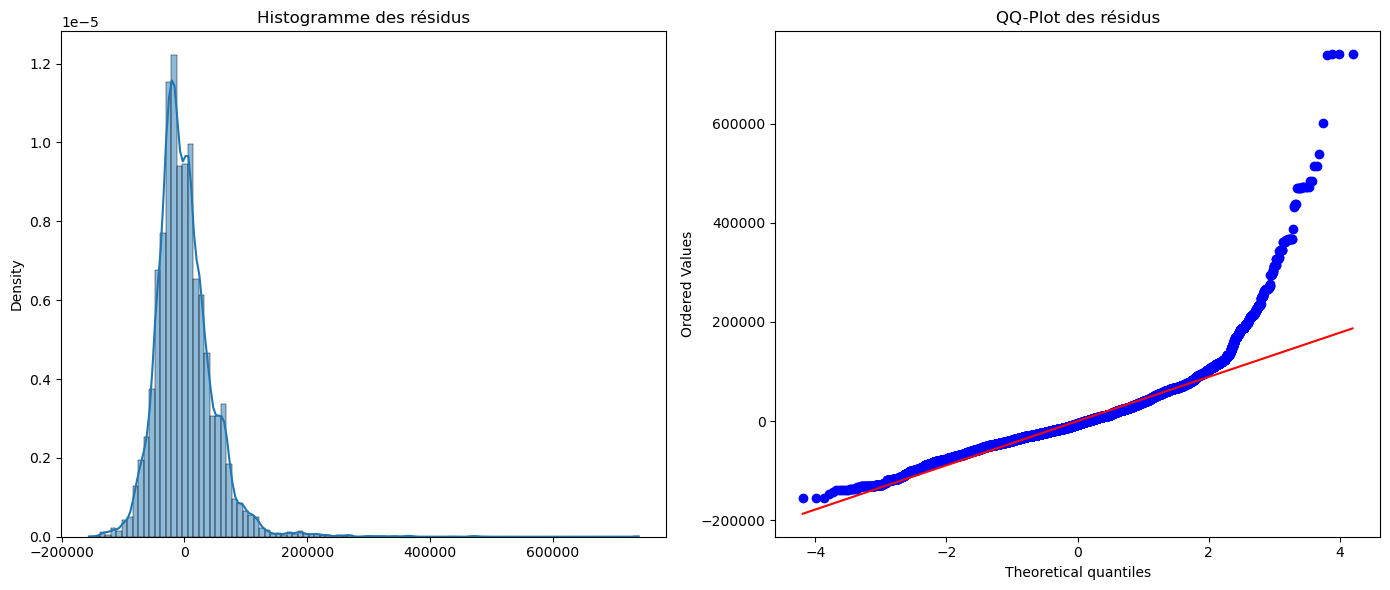

La p-value = 0.0 < 0,05, On rejette donc l'hypothèse de normalité des résidus. Les résidus ne suivent pas une loi normale.


In [62]:
# Créer une figure avec deux sous-graphes (1 ligne, 2 colonnes)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histogramme des résidus en densité
sns.histplot(model.resid, kde=True, ax=axes[0], stat="density", bins = 100)
axes[0].set_title("Histogramme des résidus")

# QQ-plot avec les résidus
stats.probplot(model.resid, dist="norm", plot=axes[1])
axes[1].set_title("QQ-Plot des résidus")

# Afficher les graphiques
plt.tight_layout()  # Ajuster les espaces entre les graphiques
plt.show()

# Test de Jarque-Bera pour tester la normalité des résidus
jb_test = jarque_bera(model.resid)
if jb_test[1] < 0.05:
    print(f"La p-value = {jb_test[1]} < 0,05, On rejette donc l'hypothèse de normalité des résidus. Les résidus ne suivent pas une loi normale.")
else:
    print(f"La p-value = {jb_test[1]} > 0,05. On accepte donc l'hypothèse de normalité des résidus. Les résidus suivent une loi normale.")

## 4.6 - Test d’indépendance des résidus (test d'autocorrélation) (Durbin-Watson)
---

## Test de Durbin-Watson pour l'autocorrélation des résidus

Le **test de Durbin-Watson** est un test statistique utilisé pour détecter l'autocorrélation des résidus dans un modèle de régression linéaire. L'autocorrélation des résidus fait référence à une situation où les erreurs (ou résidus) du modèle sont corrélées entre elles, ce qui contredit une des hypothèses classiques de la régression linéaire, à savoir que les erreurs doivent être indépendantes.

### Hypothèses du test de Durbin-Watson :

#### Hypothèse nulle $H_0$ :
Il n'y a pas d'autocorrélation des résidus (les résidus sont indépendants).

$$
H_0 : \rho = 0
$$

#### Hypothèse alternative $H_1$ :
Il existe une autocorrélation des résidus (les erreurs sont corrélées entre elles).

$$
H_1 : \rho \neq 0
$$

### Calcul du test de Durbin-Watson :

La statistique de Durbin-Watson (DW) se calcule selon la formule suivante :

$$
DW = \frac{\sum_{i=2}^{n} (e_i - e_{i-1})^2}{\sum_{i=1}^{n} e_i^2}
$$

où :
- $e_i$ est le résidu à la $i$-ème observation,
- $n$ est le nombre d'observations,
- $e_{i-1}$ est le résidu de l'observation précédente.

### Interprétation des résultats :

- Si $DW \approx 2$, il n'y a pas d'autocorrélation (les résidus sont indépendants).
- Si $DW < 2$, cela suggère une **autocorrélation positive** (les erreurs sont positives et liées, c'est-à-dire qu'une erreur positive tend à être suivie d'une autre erreur positive).
- Si $DW > 2$, cela indique une **autocorrélation négative** (les erreurs sont négatives et liées, c'est-à-dire qu'une erreur positive est suivie d'une erreur négative, et vice versa).

En général, la statistique $DW$ se situe entre 0 et 4 :
- **0** signifie une forte autocorrélation positive.
- **4** signifie une forte autocorrélation négative.
- **2** signifie aucune autocorrélation.


Durbin-Watson: 1.976929245535936
Pas d'autocorrélation détectée (résidus indépendants).


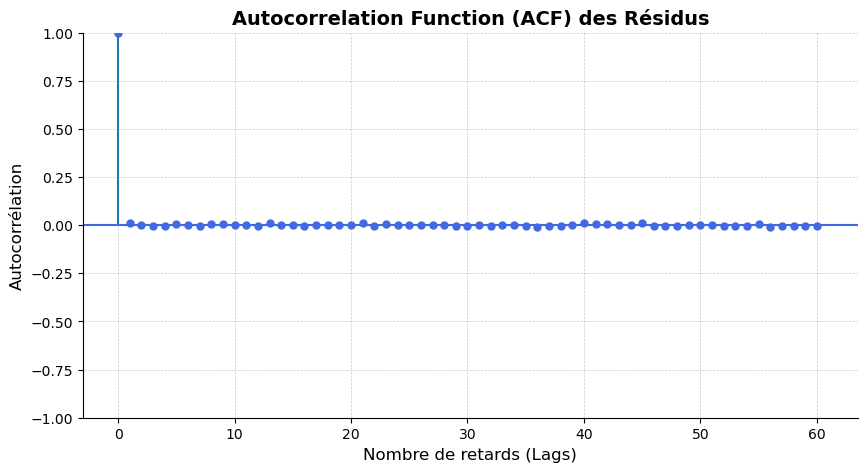

In [65]:
# Calcul du test Durbin-Watson sur les résidus du modèle
dw_stat = durbin_watson(model.resid)

# Affichage de la valeur du test
print(f"Durbin-Watson: {dw_stat}")

# Interprétation en fonction de la valeur de Durbin-Watson
if dw_stat < 1.5:
    print("Autocorrélation positive détectée (possible problème d'indépendance des résidus).")
elif dw_stat > 2.5:
    print("Autocorrélation négative détectée (possible problème d'indépendance des résidus).")
else:
    print("Pas d'autocorrélation détectée (résidus indépendants).")

# Création de la figure et du style
fig, ax = plt.subplots(figsize=(10, 5))  # Taille du graphique

# Tracer l'ACF avec des options esthétiques
plot_acf(model.resid, lags=60, ax=ax, color='royalblue', alpha=0.7)

# Personnalisation du graphique
ax.set_title("Autocorrelation Function (ACF) des Résidus", fontsize=14, fontweight='bold')
ax.set_xlabel("Nombre de retards (Lags)", fontsize=12)
ax.set_ylabel("Autocorrélation", fontsize=12)
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)  # Grille en fond
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Affichage du graphique
plt.show()

Les **lags** font référence aux **décalages temporels** entre une observation et ses valeurs passées dans une série temporelle.

### Définition des lags :
- **Lag 1** : la valeur de la série à un instant $ t $ comparée à celle à l'instant $ t-1 $ (décalage d'une période).
- **Lag 2** : la valeur à $ t $ comparée à celle à $ t-2 $, etc.

Les **lags** sont essentiels pour l'analyse de l'autocorrélation, car ils montrent comment une observation actuelle peut être influencée par ses valeurs passées.


## 4.6 - Test du modèle à des transformation (Test de Box-Cox)
---

Le test de **Box-Cox** est utilisé pour déterminer si une transformation de la variable dépendante est nécessaire dans un modèle de régression linéaire. Ce test permet de stabiliser la variance des erreurs et d'améliorer la normalité des résidus.

### Hypothèses du test de Box-Cox :

#### Hypothèse nulle ($ H_0 $) :
La variable dépendante suit déjà une distribution normale et n'a pas besoin de transformation.

$$
H_0 : \text{Aucune transformation n'est nécessaire.}
$$

#### Hypothèse alternative ($ H_1 $) :
La variable dépendante nécessite une transformation pour mieux correspondre à une distribution normale.

$$
H_1 : \text{Une transformation est nécessaire.}
$$

### Processus du test de Box-Cox :

1. **Transformation de la variable dépendante** :  
   Le test de Box-Cox consiste à tester différentes valeurs pour le paramètre de transformation $ \lambda $ de la variable dépendante $ y $. La transformation est donnée par la formule suivante :

   $$
   y(\lambda) =
   \begin{cases}
   \frac{y^\lambda - 1}{\lambda} & \text{si} \quad \lambda \neq 0 \\
   \ln(y) & \text{si} \quad \lambda = 0
   \end{cases}
   $$

   Où :
   - $ y $ est la variable dépendante,
   - $ \lambda $ est le paramètre de transformation.

2. **Estimation du modèle** :  
   Le modèle de régression est ajusté pour chaque valeur de $ \lambda $, et la log-vraisemblance est calculée pour chaque transformation.

3. **Calcul du test de Box-Cox** :  
   Le test calcule la log-vraisemblance pour différentes valeurs de $ \lambda $. La valeur optimale de $ \lambda $ est celle qui maximise cette log-vraisemblance.

4. **Décision** :  
   Si $ \lambda = 1 $, il n'est pas nécessaire de transformer la variable. Si $ \lambda \neq 1 $, une transformation est recommandée, et la valeur de $ \lambda $ indique le type de transformation nécessaire pour améliorer la normalité des erreurs et stabiliser la variance.

In [69]:
y_transformed, lambda_optimal = boxcox(Y_r)
print(f"Lambda optimal: {lambda_optimal}")

Lambda optimal: -0.7363978779772863


Ici, la valeur du lambda n'est pas égal à 1, ce qui suggère que les donnée

## 5 - Synthèse du diagnostique à postériori 
\begin{array}{|c|c|c|c|}
\hline
\textbf{Hypothèse} & \textbf{Test effectué} & \textbf{Résultat} & \textbf{Conclusion} \\
\hline
\text{1. Linéarité} & \text{Test de Rainbow} & \text{p-value = 0.36727486414813726} & \text{Rejetée} \\
\hline
\text{} & \text{Test de Ramsey} & \text{p-value = 0.0036} & \text{Rejetée} \\
\hline
\text{2. Multicolinéarité} & \text{VIF (Variance Inflation Factor)} & \text{entre 1.02 et 2.53} & \text{Validée} \\
\hline
\text{3. Homoscedasticité} & \text{Test de White} & \text{p-value = 0.0000} & \text{Rejetée} \\
\hline
\text{4. Normalité des résidus} & \text{Test de Shapiro-Wilk} & \text{p-value = 0,0} & \text{Validée} \\
\hline
\text{} & \text{Test de normalité (Jaque-Bark, Q-Q plot)} & \text{p-value = 0.0} & \text{Rejetée} \\
\hline
\text{5. Indépendance des résidus} & \text{Test de Durbin-Watson} & \text{2.001863590860673} & \text{Rejetée} \\
\hline
\text{6.transformation} & \text{Test de BoxCox} & \text{-0.7363978779772863} & \text{Validée} \\
\hline
\end{array}
